# ZIKV mutational antigenic profiling with broadly neutralizing antibodies

CK prepped samples for deep mutational scanning using known broadly neutralizing antibodies: EDE1-C8, EDE1-C10, and MZ4 alongside ZIKV-targeted mAbs ZKA64 and ZV-67 as positive controls. The virus library is a ZIKV MR766 E-protein virus library first described in Sourisseau et al J Virology.


**EDE1-C8** was prepared at 1800 ng/mL ("1800").

**EDE1-C10** was prepared at 300 ng/mL ("C10_300").

**MZ4** was prepared at 4800 ng/mL ("MZ4_4800").

**SiGN-3C** was prepared at two concentrations: 20 ug/mL ("SiGN_20") and 10 ug/mL ("SiGN_10").

**ZV-67** was prepared at 40 ug/mL ("ZV67_40000").

All antibody concentrations were incubated with 800,000 IU (MOI 1) of virus library and allowed to infect Vero cells for 24 hours prior to isolating total RNA - see [CK018](https://benchling.com/s/etr-YtBt2dzXr60FGcLKYF1C?m=slm-zQusZO8o9Qc9Egy4lYhe) for details. 

Viral cDNA libraries were generated for next-generation sequencing as outlined in [CK019](https://benchling.com/s/etr-Vp41lo9pFVD1ZcXYw0bM?m=slm-m2YLmBU986a39SRUKDYz).


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span>
    <a href="#Deep-mutational-scanning-of-ZIKV-E-protein" data-toc-modified-id="Deep-mutational-scanning-of-ZIKV-E-protein-1">Deep mutational scanning of ZIKV E protein</a></span><ul class="toc-item"><li><span>
    <a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span></li><li><span>
    <a href="#Library-sequencing-quality-control" data-toc-modified-id="Library-sequencing-quality-control-1.2">Library sequencing quality control</a></span></li><li><span>
    <a href="#Differential-selection" data-toc-modified-id="Differential selection-1.3">Differential selection</a></span></li><li><span>
    <a href="#Figures-for-paper" data-toc-modified-id="Figures-for-paper-1.4">Figures for paper</a>

# Set up analysis

In [1]:
# import tools
import os
import glob
import numpy as np
import pandas as pd
import scipy
from functools import reduce
from Bio import SeqIO
import dms_tools2
import dmslogo
from dms_tools2.ipython_utils import showPDF
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set use-existing clause for dms_tools2
use_existing = 'yes'

In [3]:
# ID input/output directories
samplelist = './data/samplelist.csv'
datadir = './data/'
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

In [4]:
# reference sequences
Erefseq = './data/E.fasta'
subamplicon_alignspecs = './data/subamplicon_alignspecs.txt'

In [5]:
# read in E protein sequence data 
refseq = SeqIO.read(Erefseq, 'fasta')
E_seq = refseq.seq
E_prot = E_seq.translate()

# Bio.SeqIO documention https://biopython.org/wiki/SeqIO

In [6]:
# read in sample list and add the sampleID 'name'
samples = (pd.read_csv(samplelist, index_col=False))
# pd.set_option('display.max_colwidth', None)
# code necessary for more recent versions of pandas (1.above) to set max column width

samples.insert(0, 'name', (samples['library'] + '-' + samples['selection']))
samples.style.hide_index()

name,library,antibody,selection,percent_infectivity,date,R1
lib1-C10-300,lib1,EDE1-C10,C10-300,0.11%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib1_C10_300_R1.fastq.gz
lib1-C8-1800,lib1,EDE1-C8,C8-1800,0.01%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib1_C8_1800_R1.fastq.gz
lib1-MZ4-4800,lib1,MZ4,MZ4-4800,0.46%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib1_MZ4_4800_R1.fastq.gz
lib1-SIgN-20000,lib1,SIgN-3C,SIgN-20000,0.21%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib1_SIgN_20000_R1.fastq.gz
lib1-ZV67-40000,lib1,ZV-67,ZV67-40000,0.84%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib1_ZV67_40000_R1.fastq.gz
lib1-no-antibody,lib1,no-antibody,no-antibody,100,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib1_no_antibody_R1.fastq.gz
lib2-C10-300,lib2,EDE1-C10,C10-300,0.23%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib2_C10_300_R1.fastq.gz
lib2-C8-1800,lib2,EDE1-C8,C8-1800,0.13%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib2_C8_1800_R1.fastq.gz
lib2-MZ4-4800,lib2,MZ4,MZ4-4800,0.02%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib2_MZ4_4800_R1.fastq.gz
lib2-SIgN-10000,lib2,SIgN-3C,SIgN-10000,0.35%,220622-230109,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_MAP_GooLab/data/concat_fastq/concat_fastq_out/lib2_SIgN_10000_R1.fastq.gz


In [7]:
# read in align specs
with open (subamplicon_alignspecs, 'r') as file:
    alignspecs = file.read().replace('\n','')
alignspecs

'1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35'

In [8]:
# process deep sequencing data: run dms2_batch_subamp

# make folder where codon counts will go
codons_batch_subamp = os.path.join(resultsdir + 'codoncounts')
os.makedirs(codons_batch_subamp, exist_ok=True)

# tell me if sample path is missing
for c in samples['R1']:
    if c == 'NaN':
       raise ValueError('samples is missing a file path')

# create df and export csv with only name/R1 for dms2_batch_subamp   
batchfile = os.path.join(datadir + 'batchSubampIDs.csv')
samples[['name','R1']].to_csv(batchfile, index=False)

# standard trim in Bloom lab analyses is 200 bp
# from documentation: "removes low-quality nucleotides that tend to be at the end of long reads"
R1TRIM = 200
R2TRIM = 200

#needs a name to run
baka = ! dms2_batch_bcsubamp \
    --batchfile {batchfile} \
    --refseq {Erefseq} \
    --alignspecs {alignspecs} \
    --outdir {codons_batch_subamp} \
    --summaryprefix summary \
    --R1trim 200 \
    --R2trim 200 \
    --ncpus 16 \
    --use_existing {use_existing}

# ! executes following code in the command line

# add column to df.samples that includes filepath to each codoncounts.csv
samples['codoncounts'] = codons_batch_subamp + '/' + samples['name'] + '_codoncounts.csv'

# tell me how you did
print(f'dms2_batch_bcsubamp {dms_tools2.__version__} aligned sequencing data and created codon count files in {codons_batch_subamp}')

dms2_batch_bcsubamp 2.6.10 aligned sequencing data and created codon count files in ./results/codoncounts


# Library sequencing quality control 
Now we'll examine some key QC aspects such as deep sequencing coverage, barcode sampling, subamplicon balancing, etc.

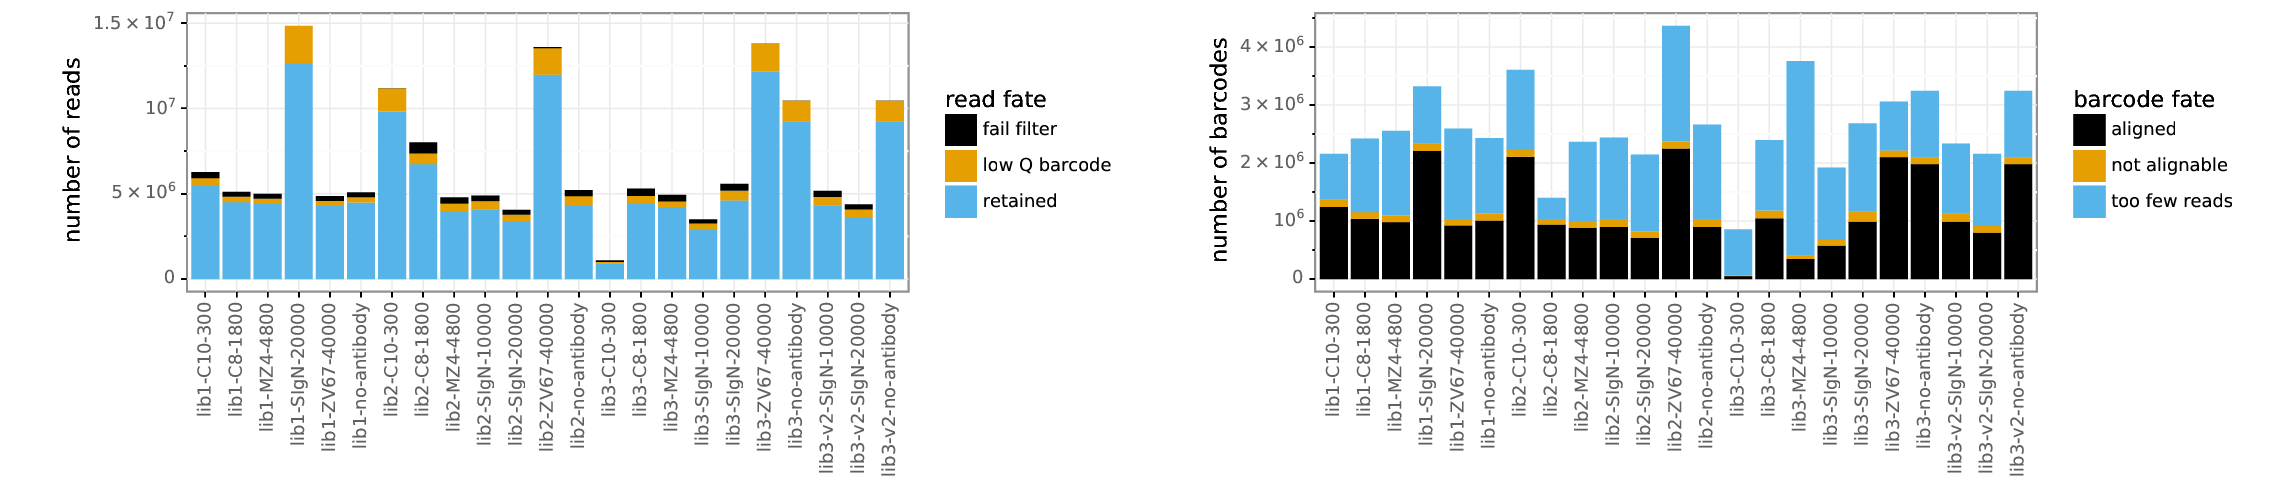

In [9]:
summary = codons_batch_subamp + "/summary_"

showPDF([os.path.join(summary + "readstats.pdf"),
         os.path.join(summary + "bcstats.pdf")])

LEFT, ABOVE: reads per sample. Per CK019 bottleneck calculations, we required ~4.5e6 per sample. This is below target as most samples are around 3e6 reads. We knew that 2 MiSeq flowcells might not be sufficient... this may be an indication of that. We can simply submit more prep for sequencing if we decide to. 

RIGHT, ABOVE: barcodes per sample. Target was 1.5e6 barcodes per sample. Aligned barcodes misses this target, with all samples falling in the 5e5-1e6 range. 

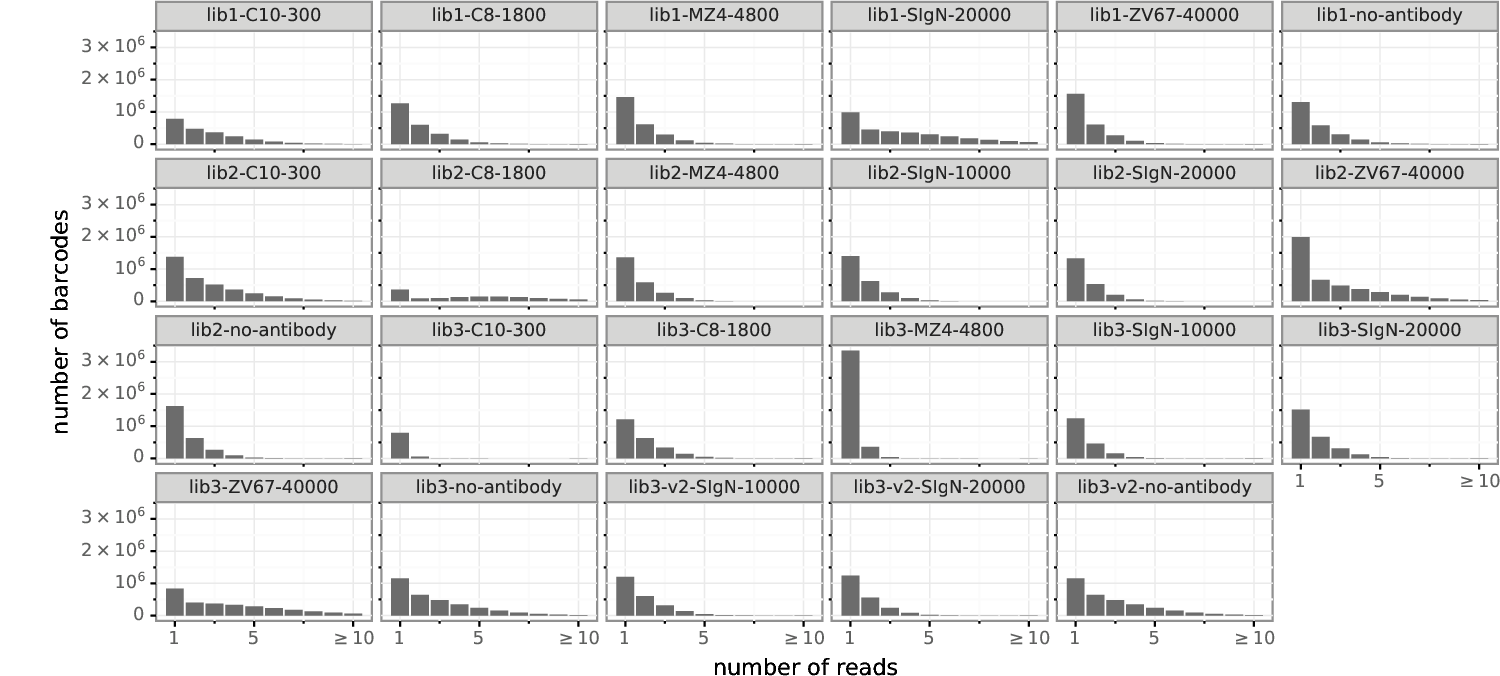

In [10]:
showPDF(os.path.join(summary + "readsperbc.pdf"))

ABOVE: reads per barcode. We need to read barcodes at least 2 times to error correct, but in many samples it looks like the majority of barcodes are being read once. This is likely due to insufficient sequencing depth.

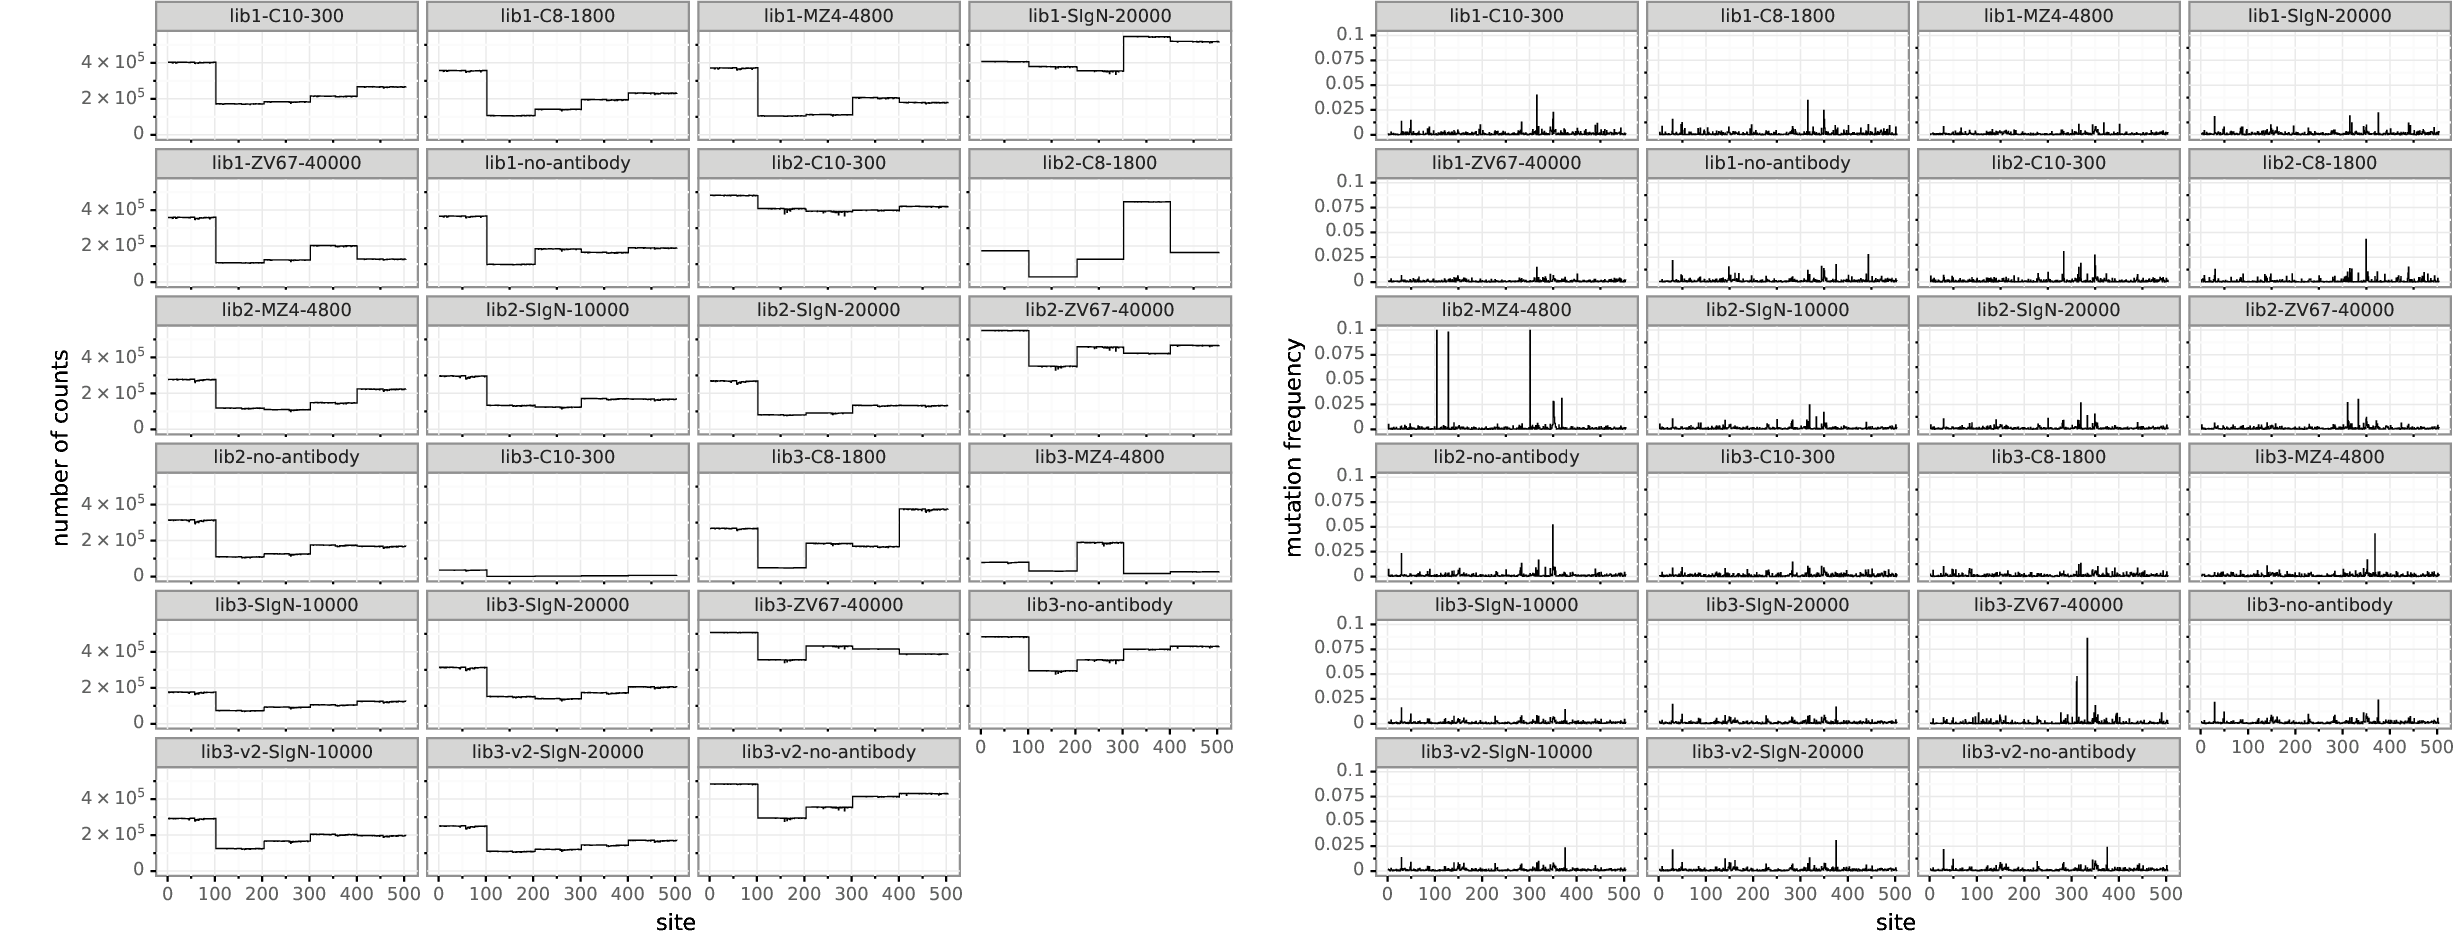

In [11]:
showPDF([os.path.join(summary + 'depth.pdf'),
         os.path.join(summary + 'mutfreq.pdf')])

LEFT, ABOVE: sequencing depth across 5 subamplicons. This looks quite uneven, especially compared to JBS083. Hopefully this resolves when we sequence more. 
RIGHT, ABOVE: mutation frequency across 5 subamplicons. Exciting to see probable selection taking place in some samples. 

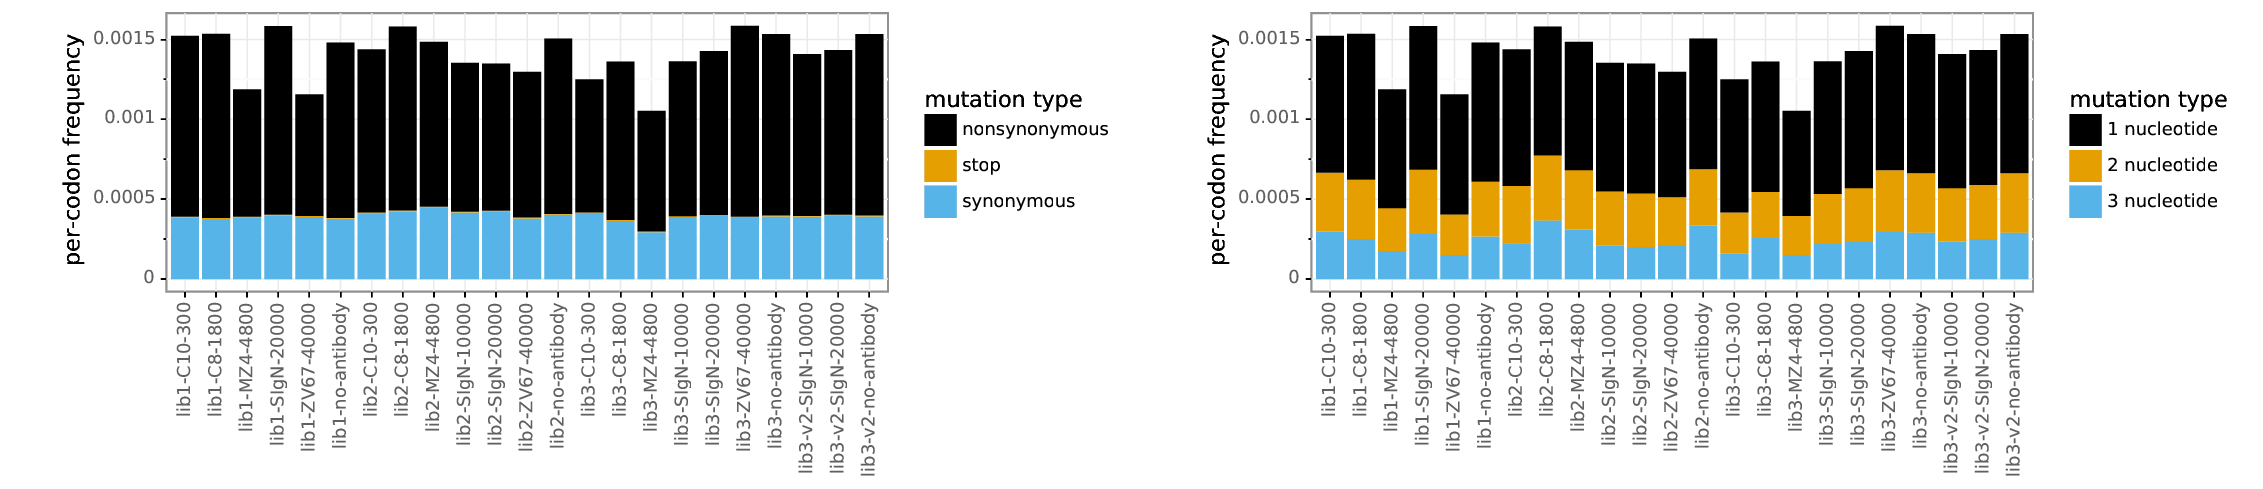

In [12]:
showPDF([os.path.join(summary + 'codonmuttypes.pdf'),
         os.path.join(summary + 'codonntchanges.pdf')])

LEFT, ABOVE: per-codon frequency of nonsynonymous, stop and synonymous mutations across samples. As expected, we see purging of stop codons in all my samples. 
RIGHT, ABOVE: per-codon frequency of 1-, 2-, or 3-nuc mutations across samples.

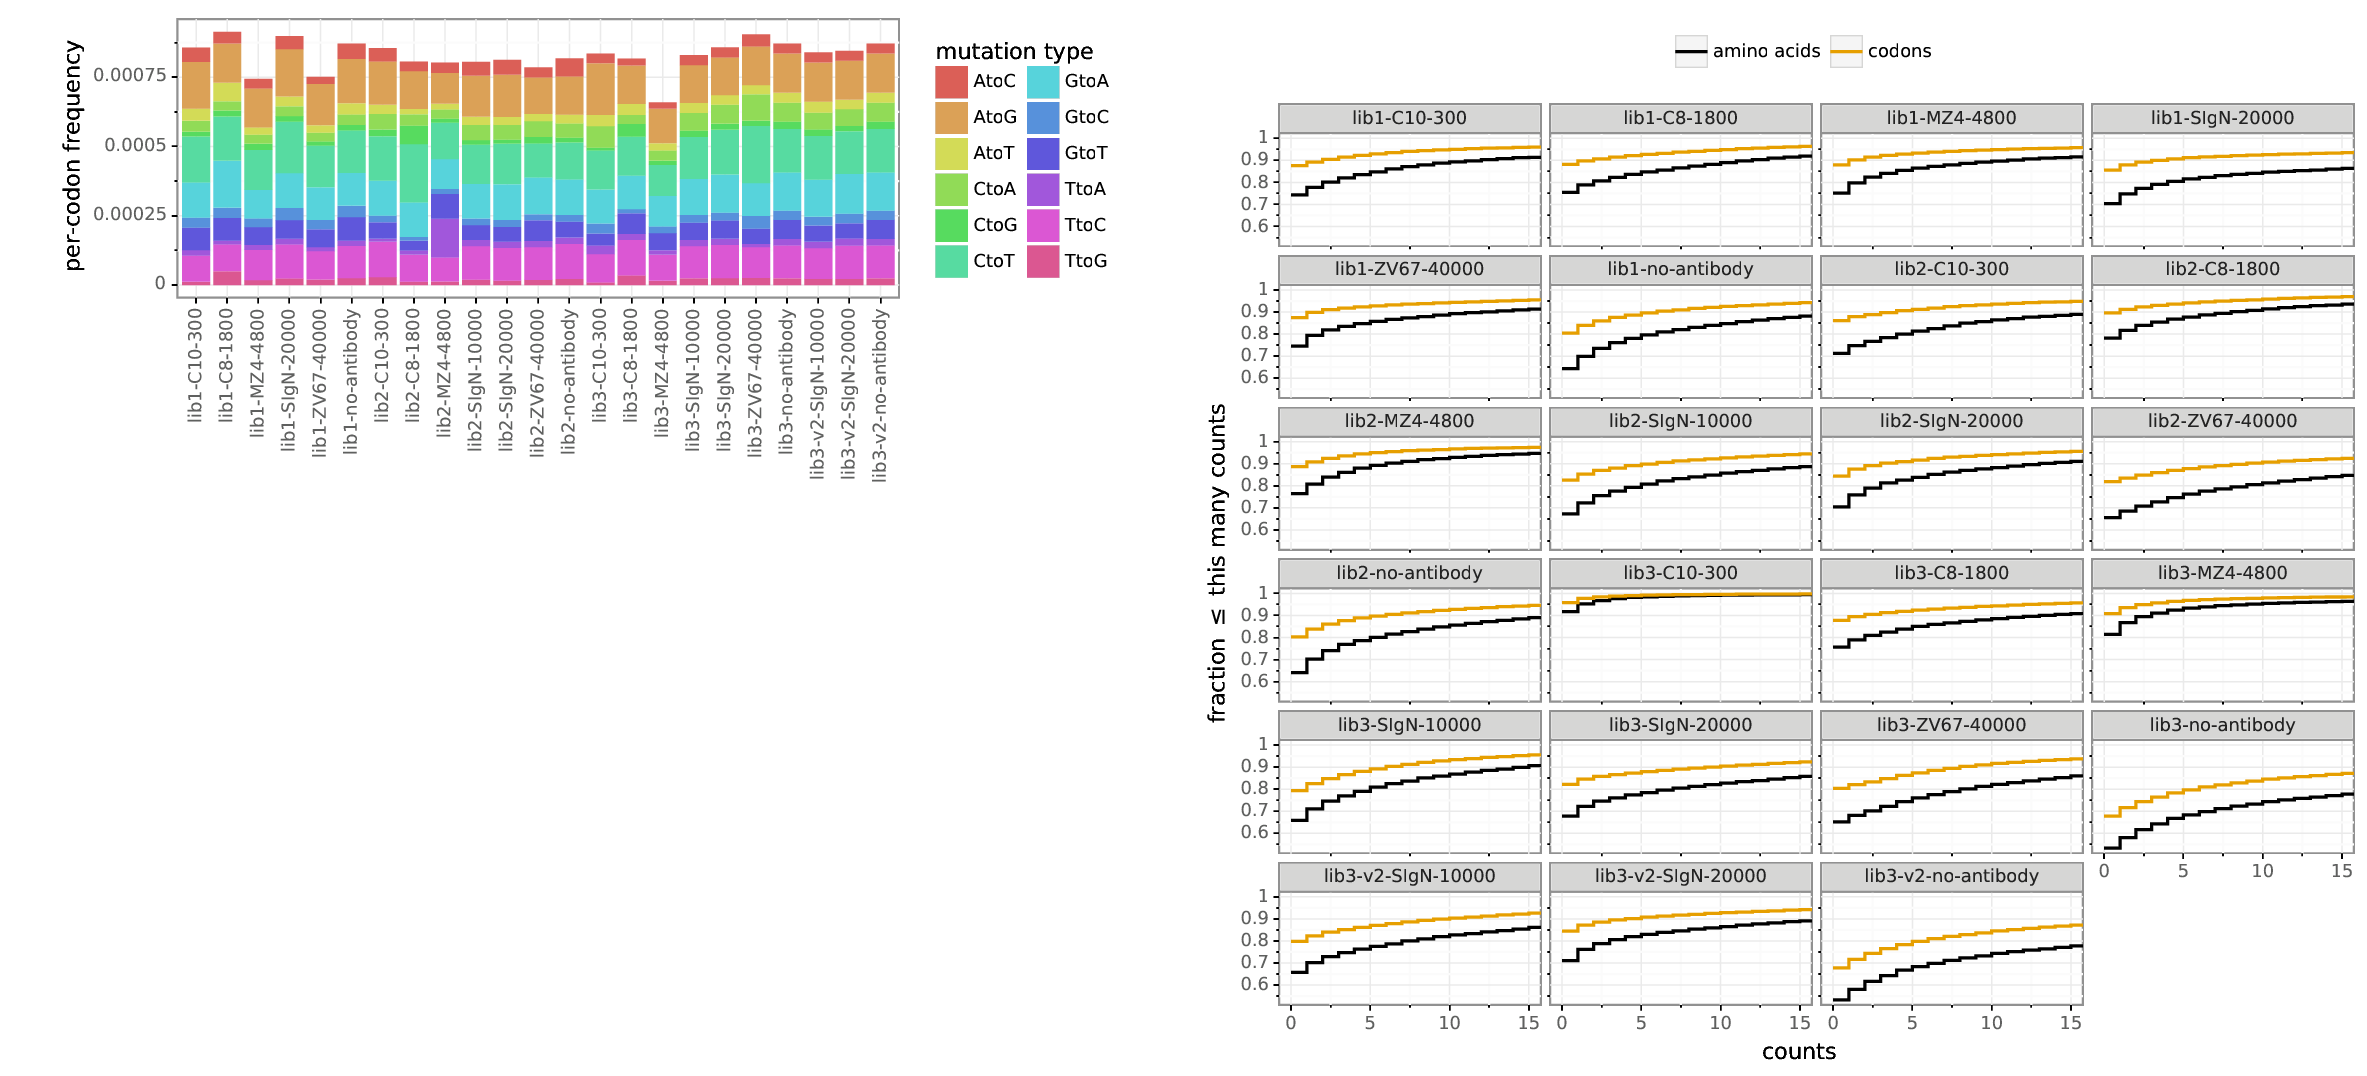

In [13]:
showPDF([os.path.join(summary + 'singlentchanges.pdf'),
         os.path.join(summary + 'cumulmutcounts.pdf')])

LEFT, ABOVE: per-codon frequency of various mutation types to evaluate for oxidative damage.
RIGHT, ABOVE: fraction of mutations that occurs a given #(count) of times. The no-ab (no antibody) control contains more diversity than the antibody- or serum-selected conditions.

# Differential selection
We now will use differential selection to quantify antibody escape for each viral mutation against our panel of antibodies. 

In [14]:
# Make base batch datafrane 
basebatch = (
    samples
    .query('selection != "no-antibody"')
    .assign(sel = lambda x: x['name'],
            group = lambda x: x['antibody'],
            mock = lambda x: x['library'] + '-no-antibody')
    .drop(columns = ['R1', 'name'])
    # .drop(none_index)
    # .drop(noAb_index)
    .assign(name = lambda x: x['library']+'-'+x['selection'])
    # .rename(columns = {'library' : 'name'})
    [['library','group', 'name', 'sel', 'mock', 'percent_infectivity']]
    .reset_index(drop = True)
    )

# make directory for individual concentrations diffsel results
diffseldir = os.path.join(resultsdir + 'diffsel')
os.makedirs(diffseldir, exist_ok = True)

# make batchfile
diffsel_batch = basebatch.rename(columns = {'group': 'antibody',
                                            # 'library': 'name',
                                            # 'name': 'group'
                                           })

# Make column labels and contents that are more interpretable and readable
diffsel_batch['grouplabel'] = (diffsel_batch['sel']
                                     .str.strip('lib1')
                                     .str.strip('lib2')
                                     .str.strip('lib3')
                                     .str.replace('-v2', '')
                                     .str.replace('-C10', 'broad antibody EDE1-C10: ')
                                     .str.replace('-C8', 'broad antibody EDE1-C8: ')
                                     .str.replace('-MZ4', 'pseudo-broad antibody MZ4: ')
                                     .str.replace('-SIgN', 'broad antibody SIgN-3C: ')
                                     .str.replace('-ZV67', 'targeted antibody ZV-67: ')
                                     .str.replace(' -', ' (')
                                     + ' ng/mL)'
                                    )
diffsel_batch['conc'] = (diffsel_batch['sel']
                         .str.split('-').str[-1]
                        ).astype(float)

diffsel_batch['group'] = (diffsel_batch['antibody'] + '-' + diffsel_batch['conc'].astype(int).astype(str))


# Sort based on custom list
sorter = ['SIgN-3C', 'EDE1-C8', 'EDE1-C10', 'MZ4', 'ZV-67']
# Custom lexicographical sort
sorterIndex = dict(zip(sorter, range(len(sorter))))
diffsel_batch['antibody_rank'] = diffsel_batch['antibody'].map(sorterIndex)
diffsel_batch.sort_values(['antibody_rank', 'name', 'conc'],
        ascending = [False, True, True], inplace = True)

# Other fiddly changes
diffsel_batch = (diffsel_batch     
                # Reorder columns
                 [[
                     'antibody', 
                   'group', 'name', 'sel', 'mock', 'percent_infectivity', 
                   'grouplabel'
                  ]]
                 .reset_index(drop=True)
                 # .rename(columns = {'group': 'name'})
                )
diffsel_batch['name'] = (diffsel_batch['name']

                                     .str.replace('lib3-v2', 'replicate3v2')
                                     .str.split('-').str[0]
                                     .str.replace('lib1', 'replicate1')
                                     .str.replace('lib2', 'replicate2')
                                     .str.replace('lib3', 'replicate3')

                                     # .str.replace('C10', 'EDE1-C10')
                                     # .str.replace('C8', 'EDE1-C8')
                                     # .str.replace('SIgN', 'SIgN-3C')
                                     # .str.replace('ZV67', 'ZV-67')
                               )




# # write individual concentration diffsel batchfile to csv
diffsel_batchfile = os.path.join(diffseldir + '/batch.csv')
diffsel_batch.to_csv(diffsel_batchfile, index = False)

diffsel_batch

,antibody,group,name,sel,mock,percent_infectivity,grouplabel
0,ZV-67,ZV-67-40000,replicate1,lib1-ZV67-40000,lib1-no-antibody,0.84%,targeted antibody ZV-67: (40000 ng/mL)
1,ZV-67,ZV-67-40000,replicate2,lib2-ZV67-40000,lib2-no-antibody,0.89%,targeted antibody ZV-67: (40000 ng/mL)
2,ZV-67,ZV-67-40000,replicate3,lib3-ZV67-40000,lib3-no-antibody,0.01%,targeted antibody ZV-67: (40000 ng/mL)
3,MZ4,MZ4-4800,replicate1,lib1-MZ4-4800,lib1-no-antibody,0.46%,pseudo-broad antibody MZ4: (4800 ng/mL)
4,MZ4,MZ4-4800,replicate2,lib2-MZ4-4800,lib2-no-antibody,0.02%,pseudo-broad antibody MZ4: (4800 ng/mL)
5,MZ4,MZ4-4800,replicate3,lib3-MZ4-4800,lib3-no-antibody,0.05%,pseudo-broad antibody MZ4: (4800 ng/mL)
6,EDE1-C10,EDE1-C10-300,replicate1,lib1-C10-300,lib1-no-antibody,0.11%,broad antibody EDE1-C10: (300 ng/mL)
7,EDE1-C10,EDE1-C10-300,replicate2,lib2-C10-300,lib2-no-antibody,0.23%,broad antibody EDE1-C10: (300 ng/mL)
8,EDE1-C10,EDE1-C10-300,replicate3,lib3-C10-300,lib3-no-antibody,0.39%,broad antibody EDE1-C10: (300 ng/mL)
9,EDE1-C8,EDE1-C8-1800,replicate1,lib1-C8-1800,lib1-no-antibody,0.01%,broad antibody EDE1-C8: (1800 ng/mL)


In [15]:
# run dms2_batch_diffsel for individual concentration batchfile
log = ! dms2_batch_diffsel \
        --batchfile {diffsel_batchfile} \
        --summaryprefix summary \
        --indir {codons_batch_subamp} \
        --outdir {diffseldir} \
        --ncpus 16 \
        --use_existing {use_existing}


Replicate correlations for ZV-67-40000


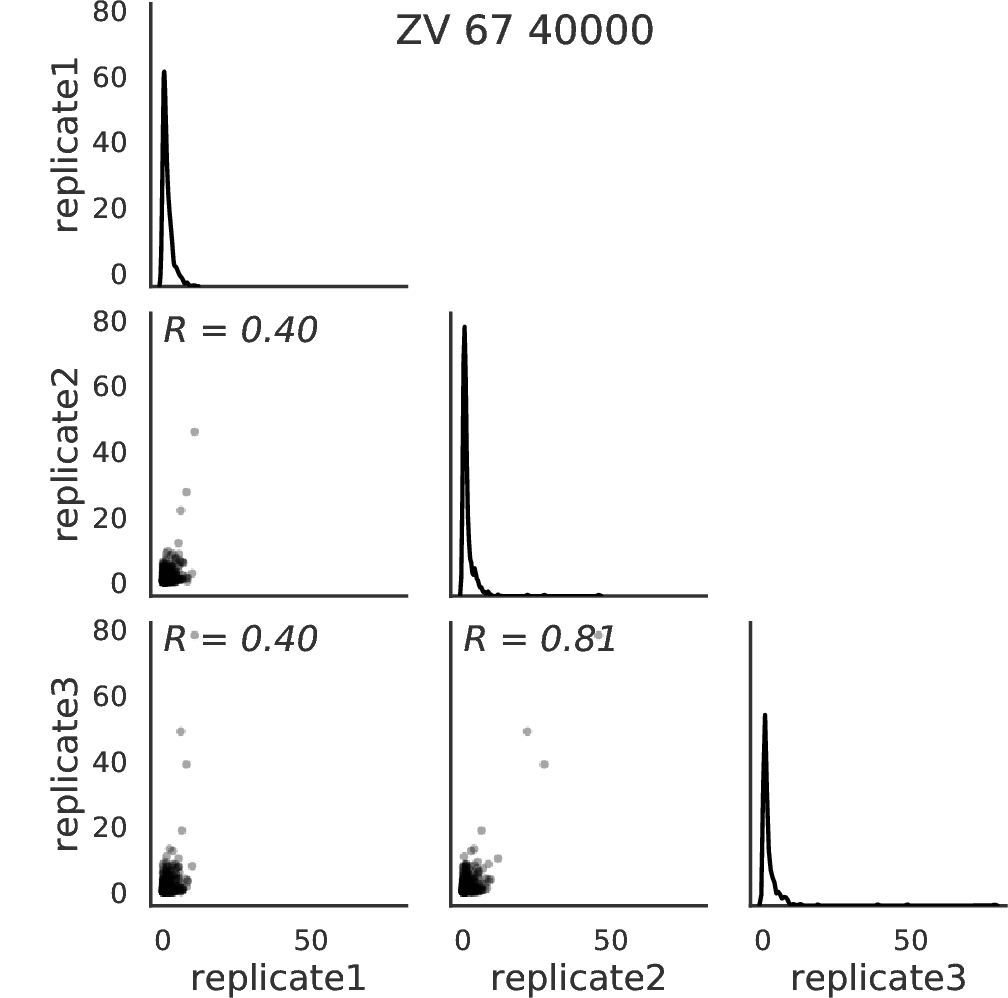


Replicate correlations for MZ4-4800


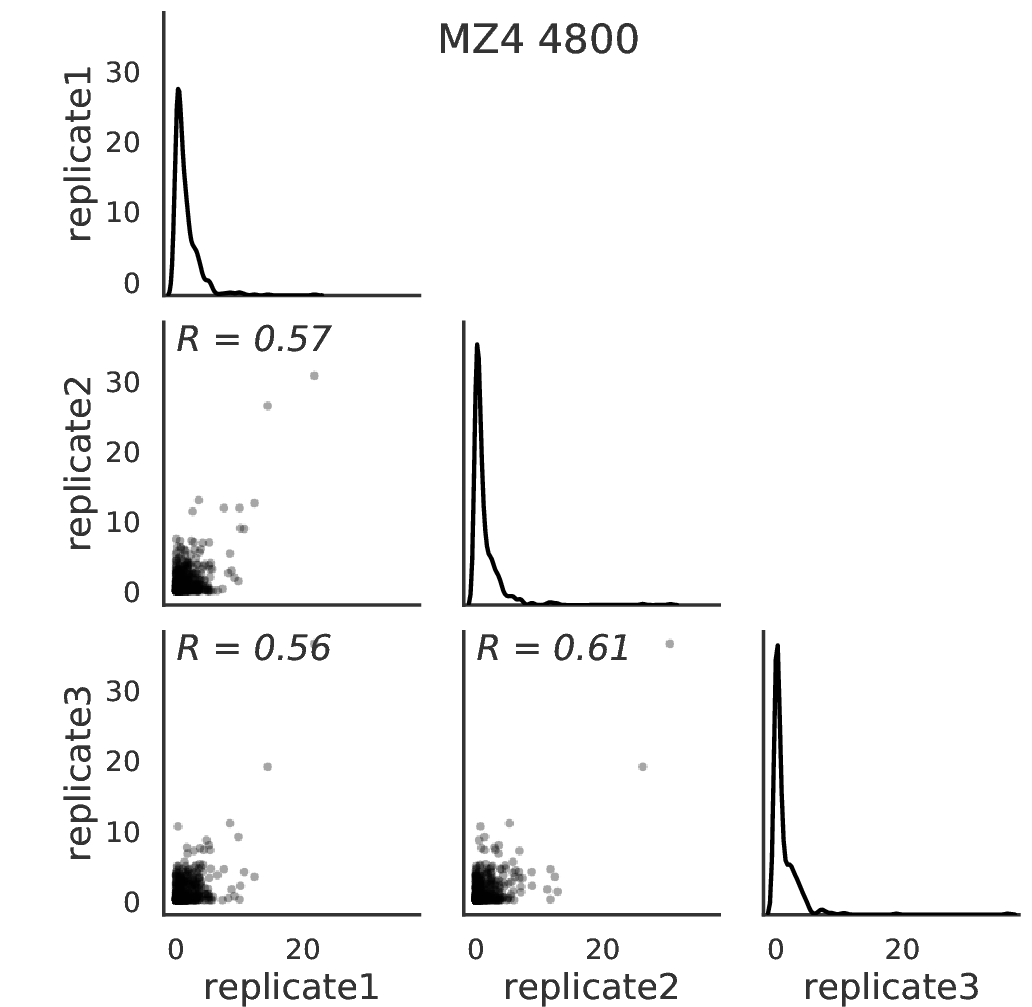


Replicate correlations for EDE1-C10-300


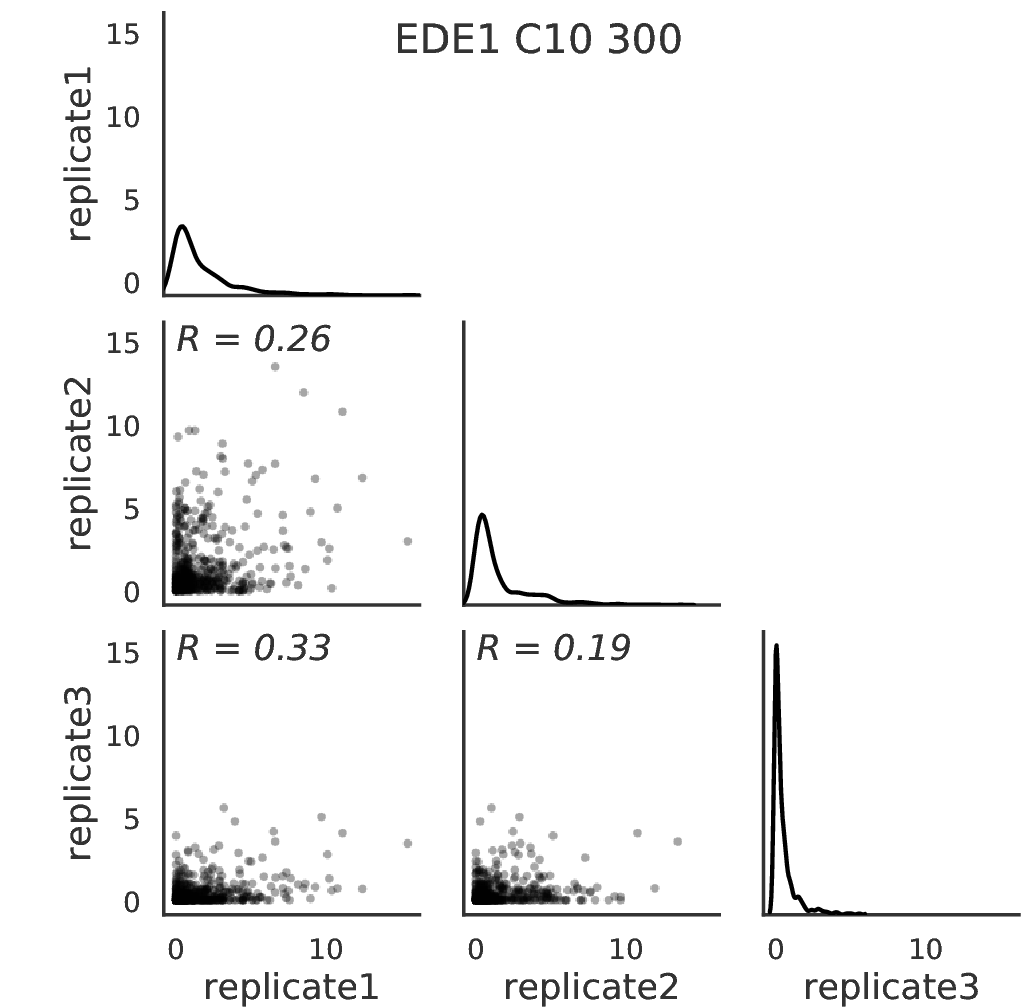


Replicate correlations for EDE1-C8-1800


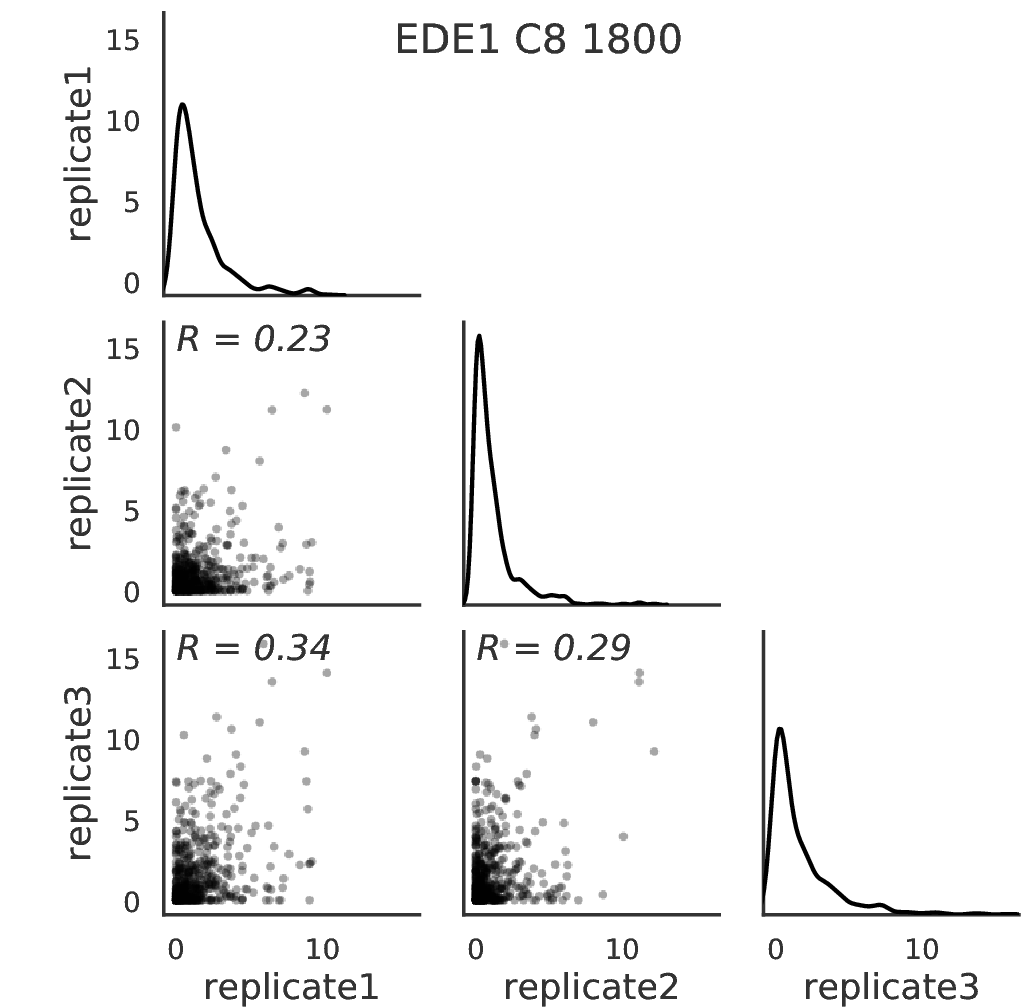


Replicate correlations for SIgN-3C-20000


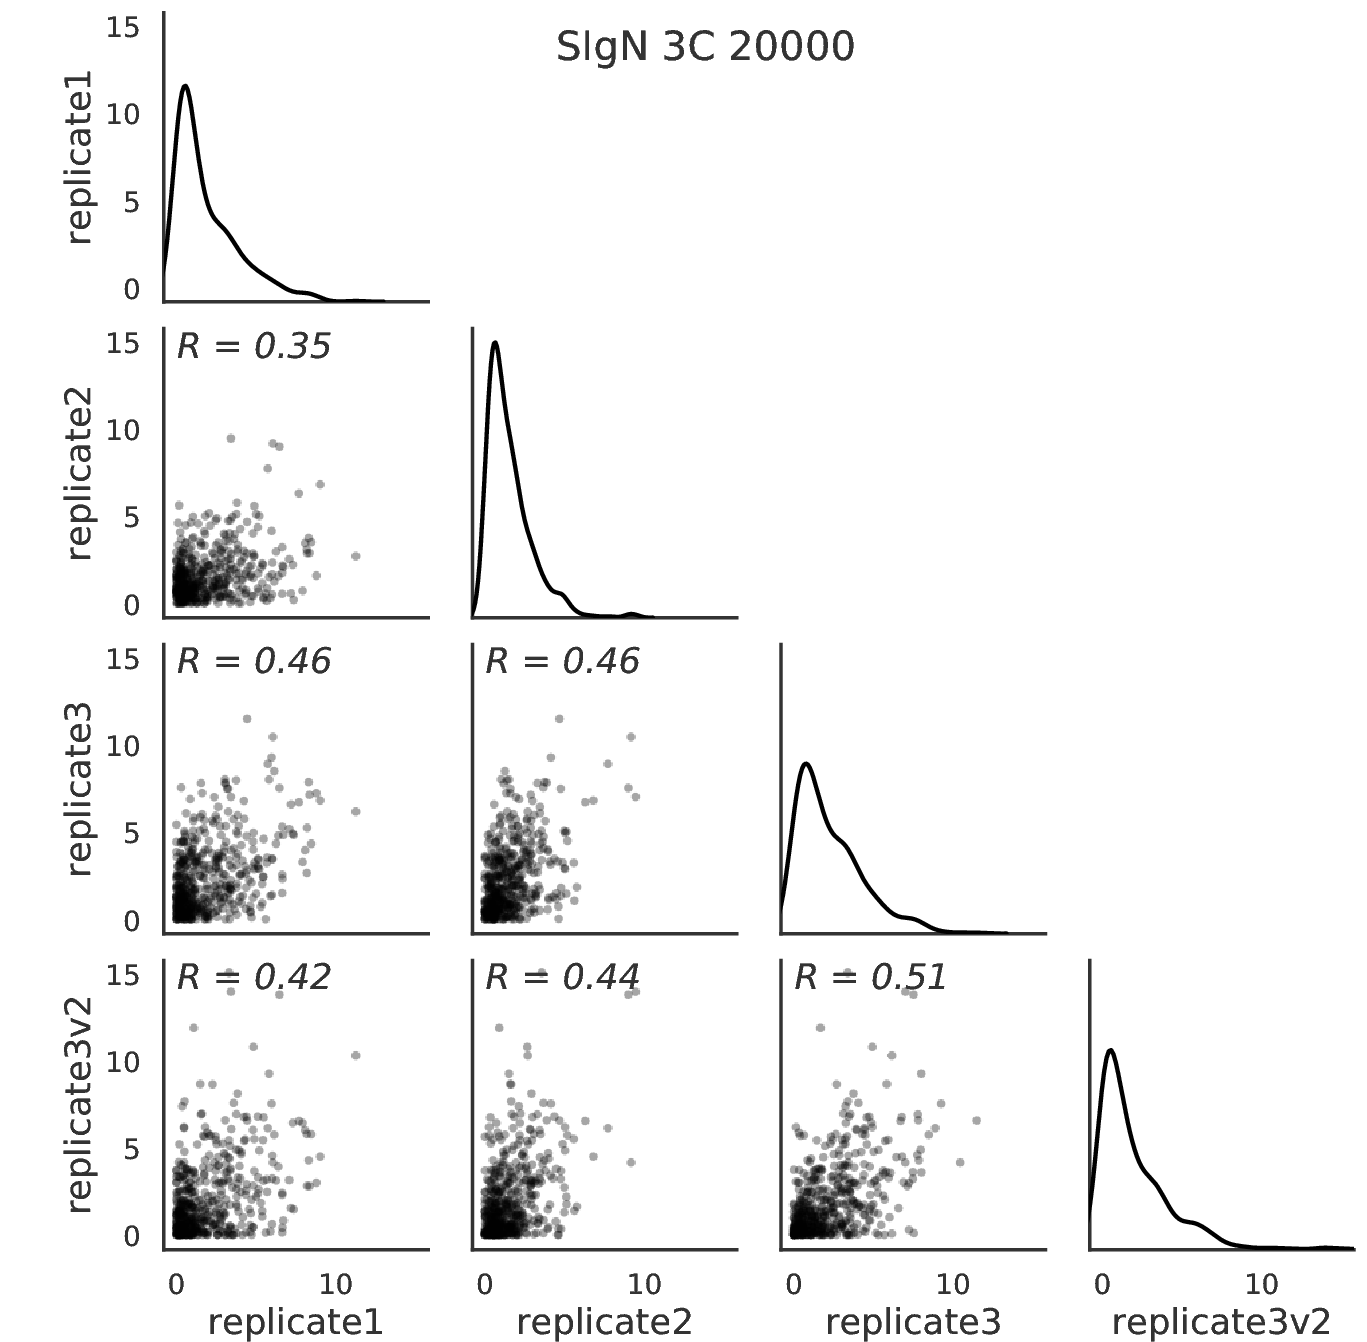


Replicate correlations for SIgN-3C-10000


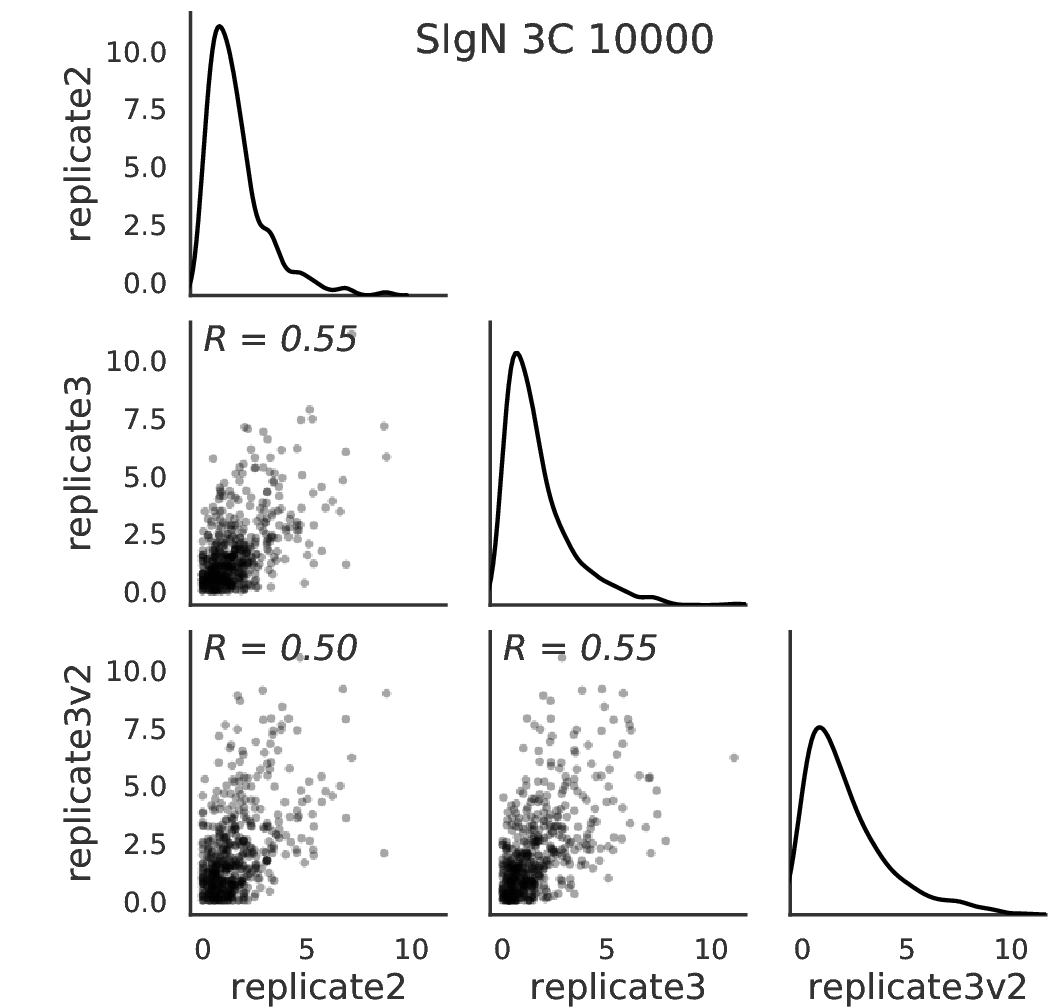

In [16]:
# Define prefix for excess fraction surviving files to use
diffselprefix = os.path.join(diffseldir, 'summary_')

# Show OVERALL correlation plots for each of the above antibodies
for antibody in diffsel_batch['group'].unique():
    plot = [diffselprefix + antibody + '-positivesitediffselcorr.pdf']
    print(f"\nReplicate correlations for {antibody}")
    showPDF(plot)

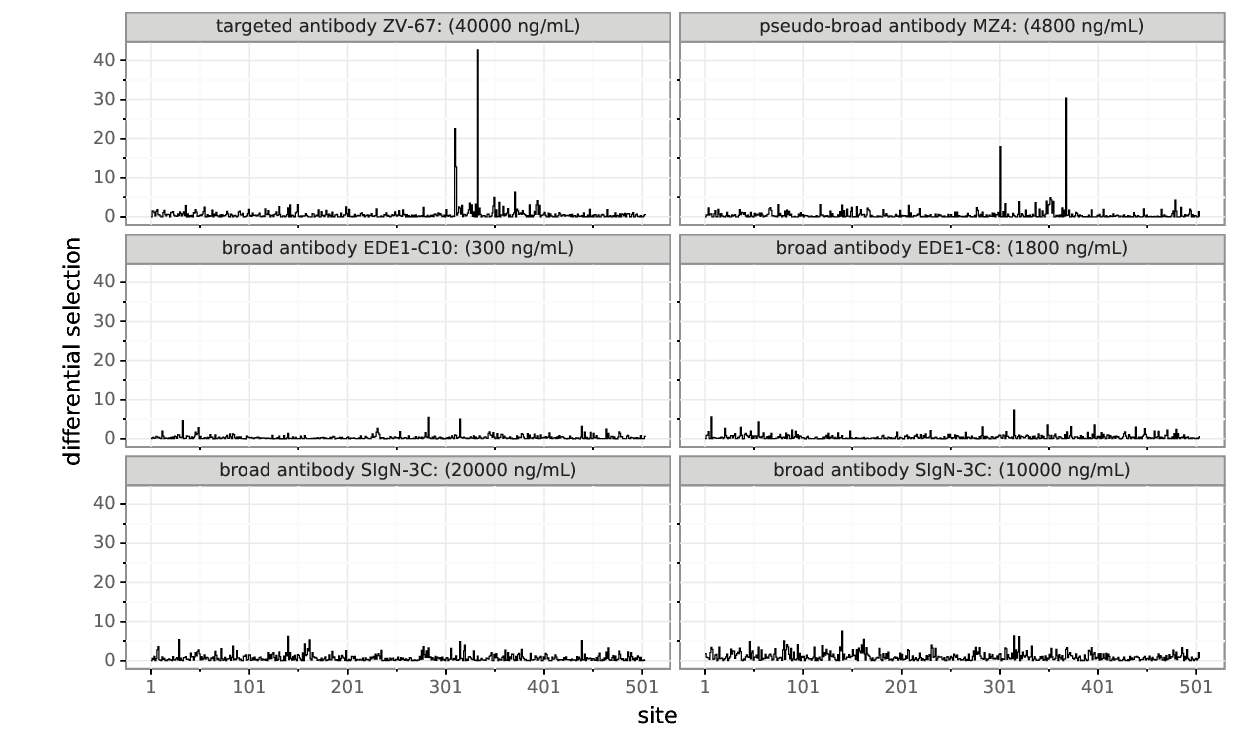

In [17]:
# Show lineplot from each antibody concentration
plot = diffselprefix + 'medianpositivediffsel.pdf'
showPDF(plot)

In [18]:
# for each antibody group AND concentration in diffsel batchfile, run dms2_logoplot to show aa-level differential selection
for ab in diffsel_batch.query('group != "control-antibody"').group.unique():
    diffselfile = os.path.join(diffseldir, f'summary_{ab}-medianmutdiffsel.csv')
    baka = ! dms2_logoplot \
        --outdir {diffseldir} \
        --ncpus 16 \
        --name {ab} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 101 \
        --numberevery 5 \
        --scalebar 2 "diffsel = 2" \
        --underlay yes \
        --overlay1 {diffselfile} wildtype wildtype \
        --use_existing 'no'



Getting and plotting overall across-concentration median for ZV-67
Here are the top 5 mutation-level effects...
   site wildtype mutation  mutdiffsel
0   333        A        W    5.220291
1   333        A        E    5.128572
2   333        A        L    5.077331
3   333        A        Q    5.061331
4   310        A        D    4.846885
Here are the top 10 site-level effects...
mutation  site  positive_diffsel
0          333         42.666457
1          310         22.563684
2          311         12.796853
3          371          6.305352
4          350          4.983127
5          394          4.153731
6          355          3.679925
7          325          3.522249
8          331          3.238815
9          150          3.133429
Writing across-concentration medians to ./results/diffsel/antibody_ZV-67_median.csv
Writing across-concentration site medians to ./results/diffsel/antibody_ZV-67_median_avgsite.csv
{'ZV-67': [333, 310]}
Creating logo plot ./results/diffsel/ZV-67_diffsel.

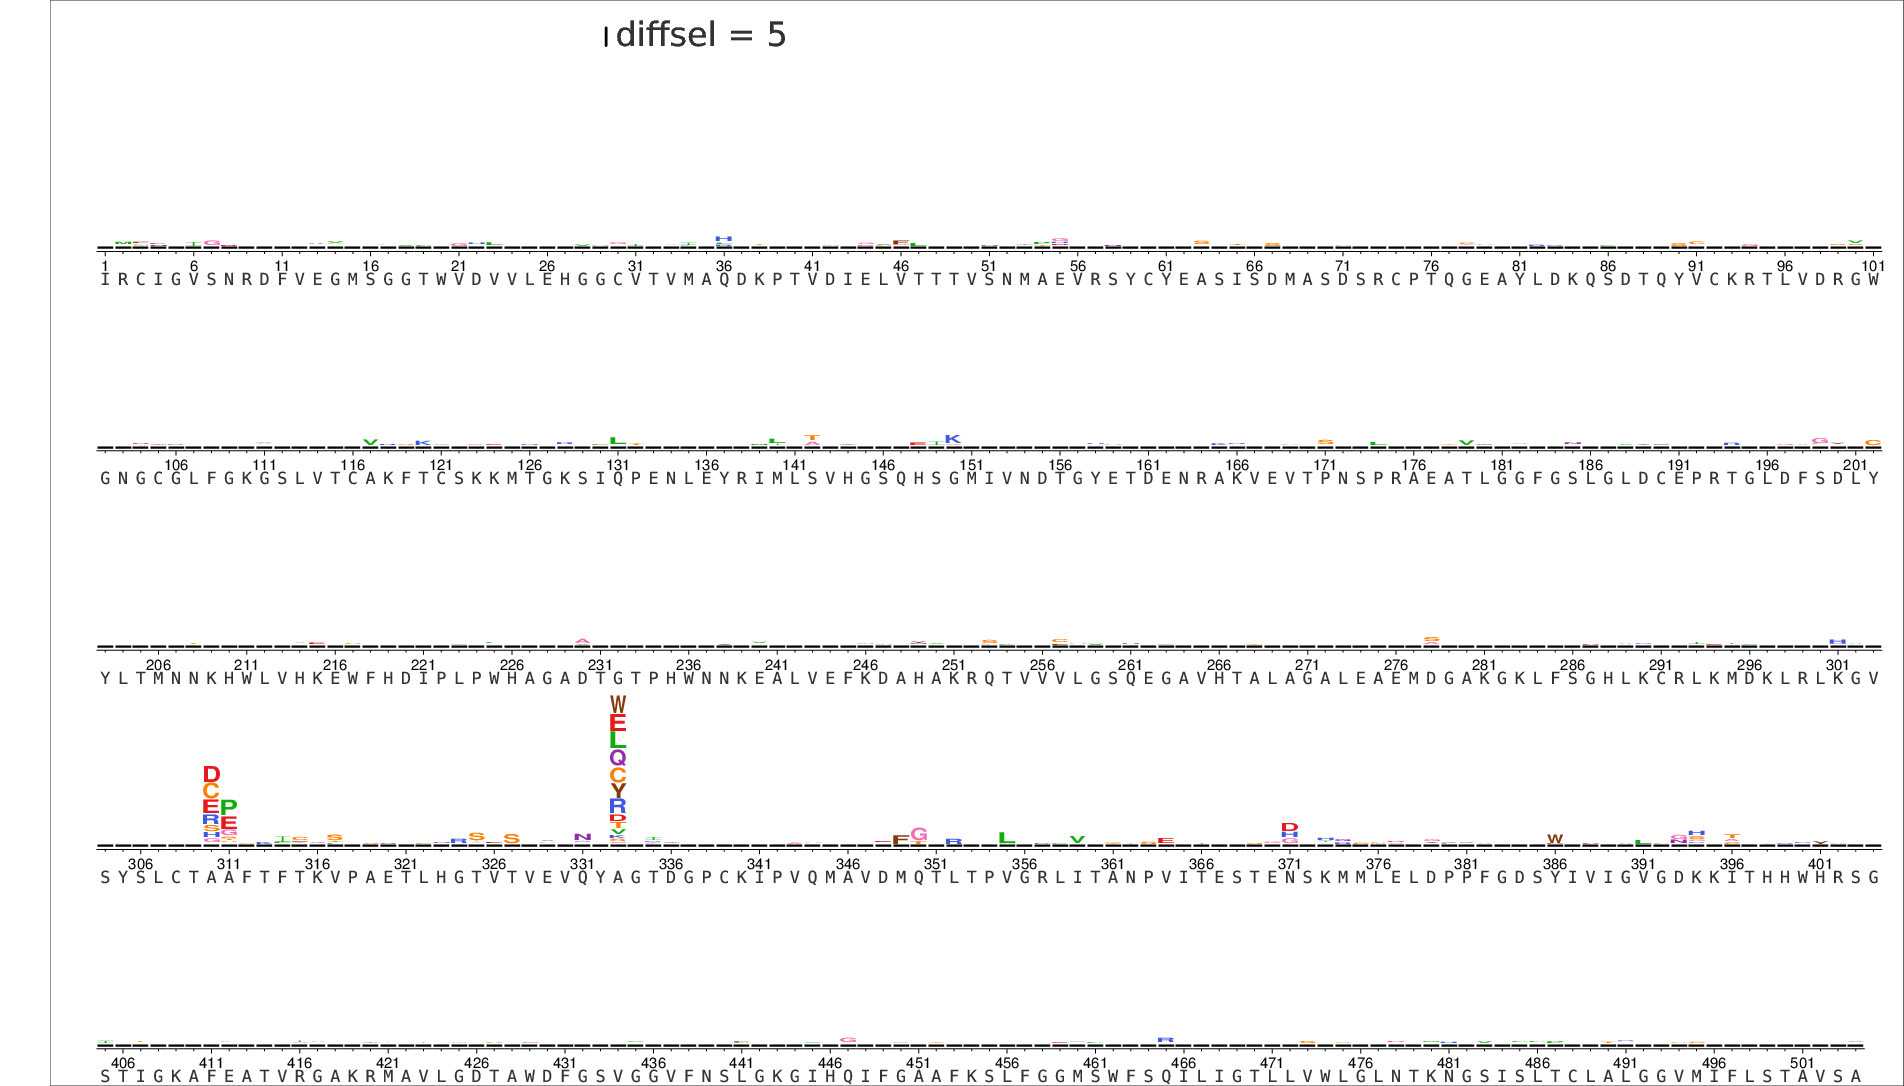


Getting and plotting overall across-concentration median for MZ4
Here are the top 5 mutation-level effects...
   site wildtype mutation  mutdiffsel
0   301        K        H    4.217704
1   479        T        G    4.011507
2   301        K        Y    3.940772
3   368        S        L    3.929273
4   368        S        V    3.823385
Here are the top 10 site-level effects...
mutation  site  positive_diffsel
0          368         30.324081
1          301         17.964025
2          352          4.915727
3          353          4.324830
4          479          4.242705
5          348          3.985321
6          355          3.936266
7          320          3.908599
8          337          3.652867
9          306          3.374493
Writing across-concentration medians to ./results/diffsel/antibody_MZ4_median.csv
Writing across-concentration site medians to ./results/diffsel/antibody_MZ4_median_avgsite.csv
{'ZV-67': [333, 310], 'MZ4': [368, 301, 479]}
Creating logo plot ./results/diff

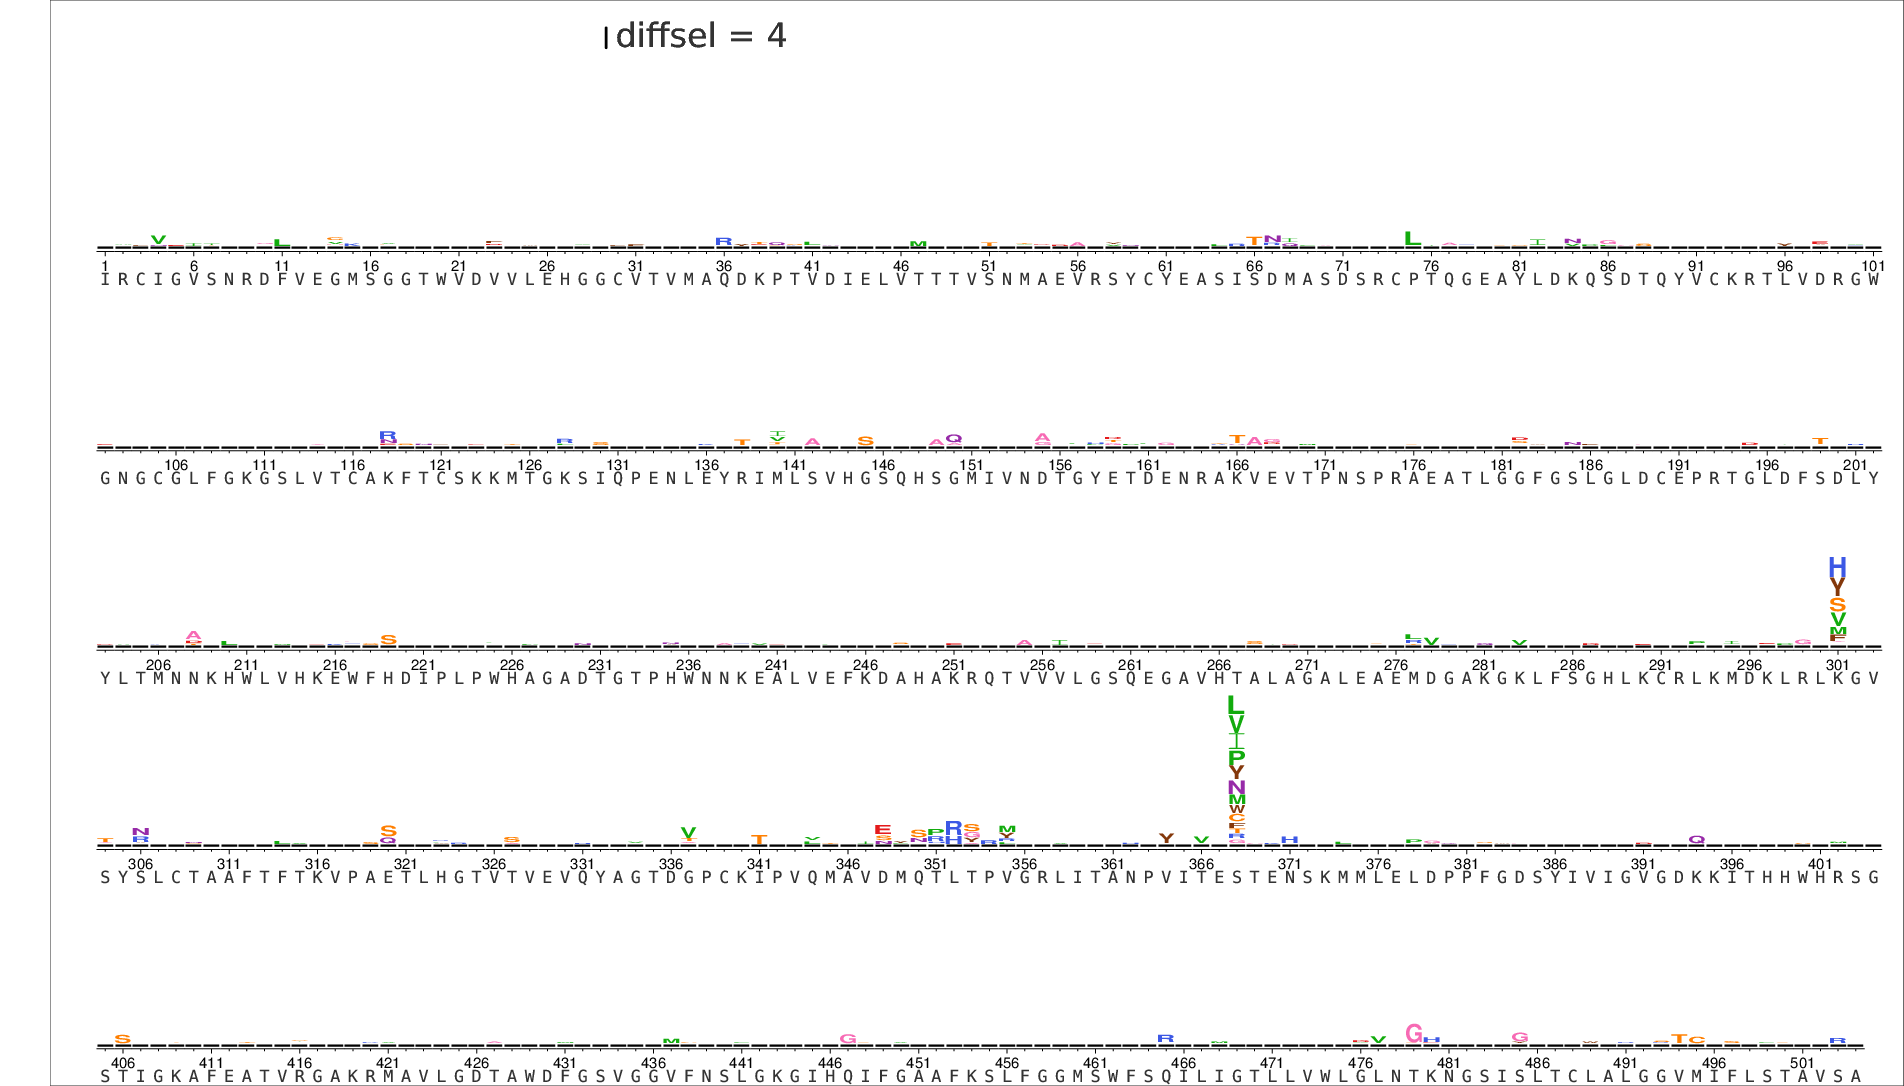


Getting and plotting overall across-concentration median for EDE1-C10
Here are the top 5 mutation-level effects...
   site wildtype mutation  mutdiffsel
0    33        V        I    4.582371
1    49        T        D    2.497055
2   231        T        R    2.428671
3   464        S        L    2.335385
4   439        N        K    1.837236
Here are the top 10 site-level effects...
mutation  site  positive_diffsel
0          283          5.435655
1          315          5.035614
2           33          4.649977
3          439          3.173396
4           49          2.844304
5          231          2.629227
6          464          2.457810
7           12          1.954235
8          254          1.838681
9          345          1.761304
Writing across-concentration medians to ./results/diffsel/antibody_EDE1-C10_median.csv
Writing across-concentration site medians to ./results/diffsel/antibody_EDE1-C10_median_avgsite.csv
{'ZV-67': [333, 310], 'MZ4': [368, 301, 479], 'EDE1-C10': [315, 

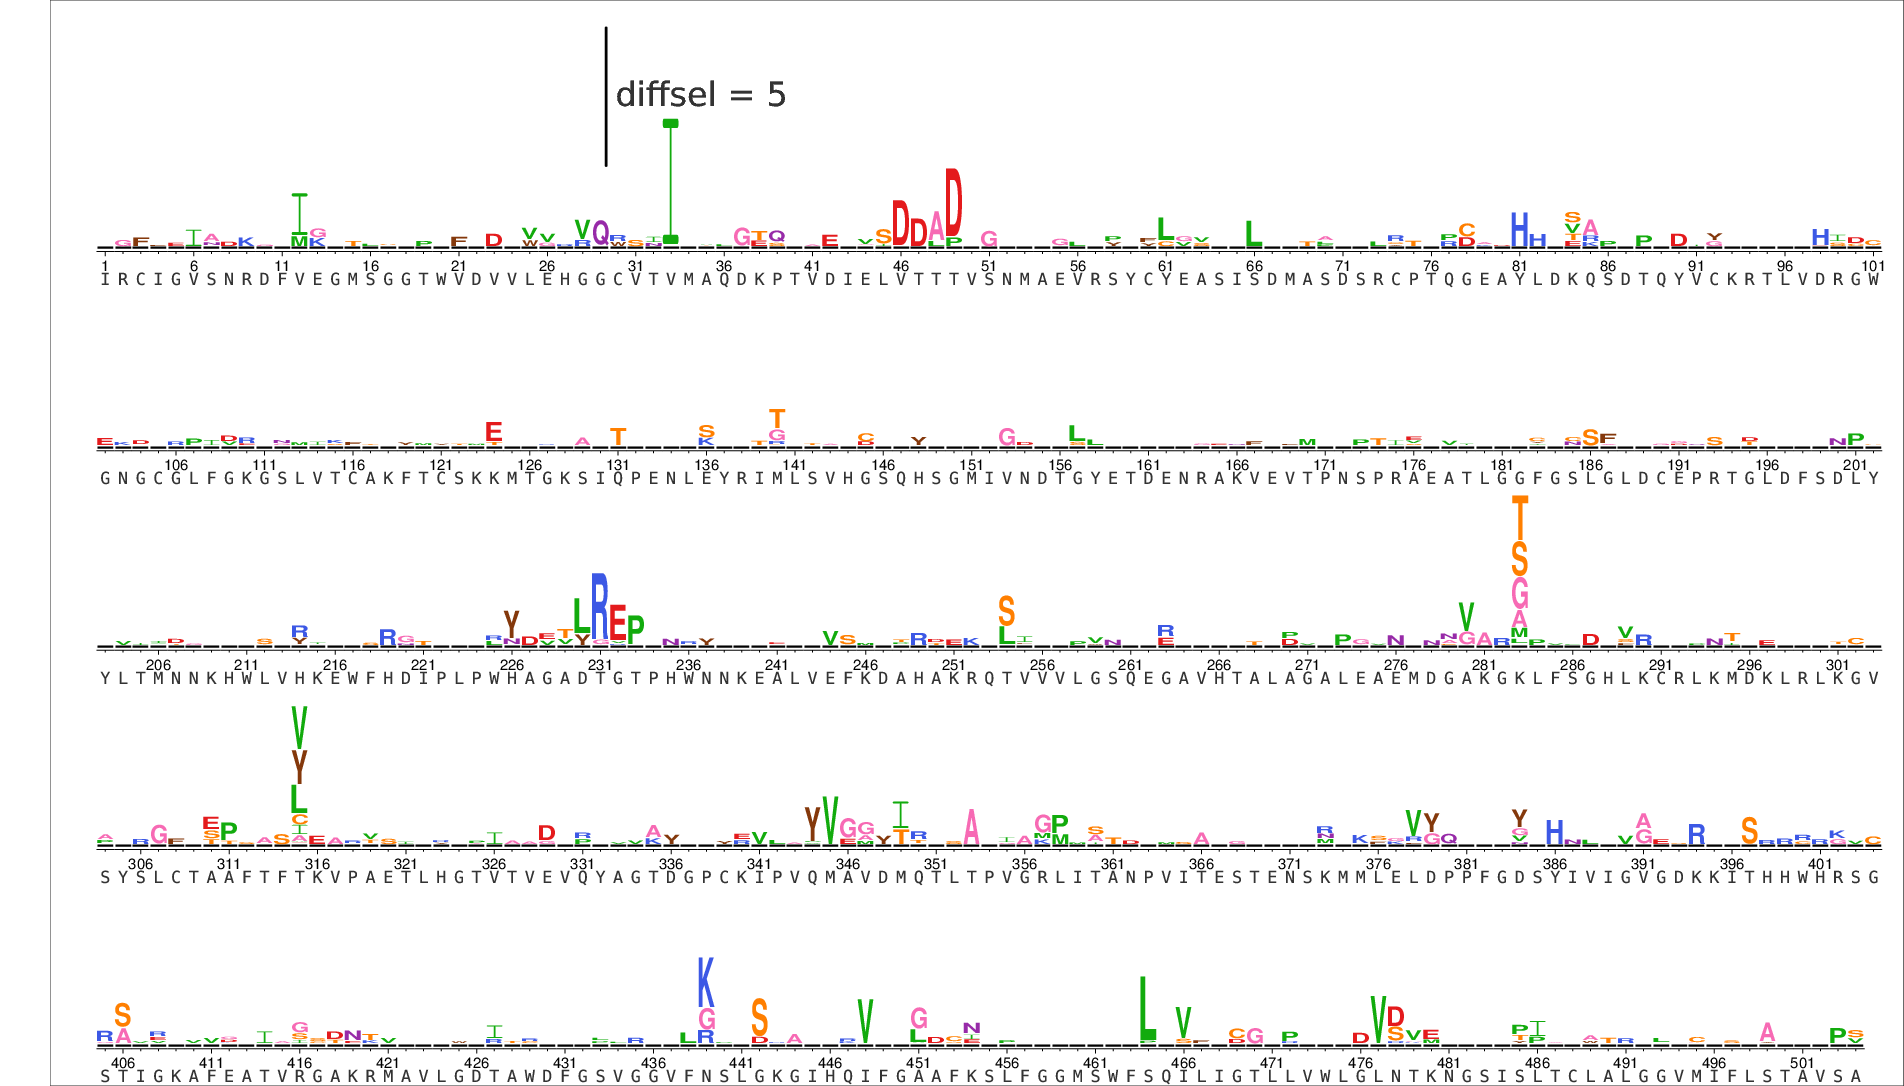


Getting and plotting overall across-concentration median for EDE1-C8
Here are the top 5 mutation-level effects...
   site wildtype mutation  mutdiffsel
0   397        T        G    3.517528
1   439        N        K    2.968811
2   349        M        E    2.773152
3    55        E        V    2.677955
4     7        S        P    2.620159
Here are the top 10 site-level effects...
mutation  site  positive_diffsel
0          315          7.329833
1            7          5.568574
2           55          4.304360
3          349          3.546344
4          397          3.523397
5          373          3.074773
6          283          3.049768
7          439          2.985281
8           37          2.879558
9           21          2.640162
Writing across-concentration medians to ./results/diffsel/antibody_EDE1-C8_median.csv
Writing across-concentration site medians to ./results/diffsel/antibody_EDE1-C8_median_avgsite.csv
{'ZV-67': [333, 310], 'MZ4': [368, 301, 479], 'EDE1-C10': [315, 283

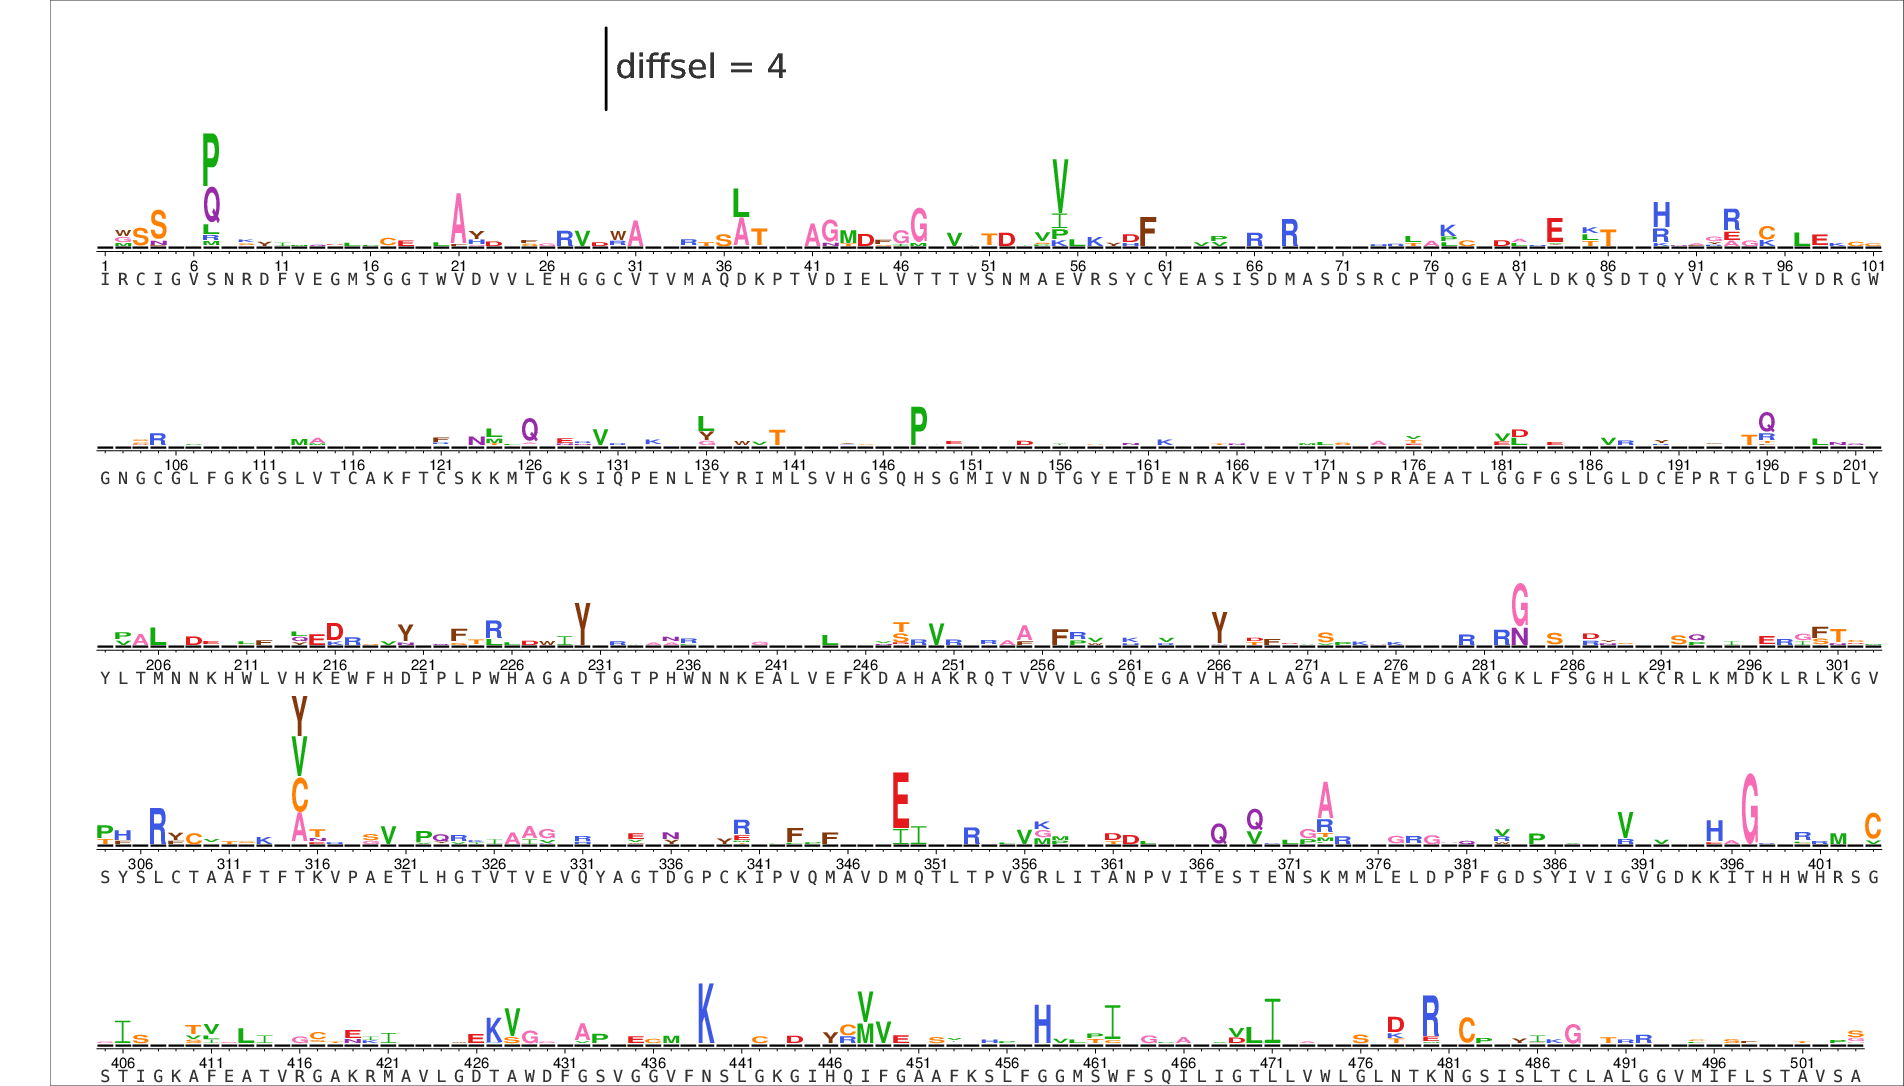


Getting and plotting overall across-concentration median for SIgN-3C
Here are the top 5 mutation-level effects...
   site wildtype mutation  mutdiffsel
0     8        N        T    2.433386
1    72        S        G    1.871529
2    29        G        Q    1.772030
3    49        T        D    1.742743
4   320        E        S    1.566200
Here are the top 10 site-level effects...
mutation  site  positive_diffsel
0          140          6.606207
1          315          5.459780
2          162          4.396402
3          320          4.185990
4           29          3.860917
5          157          3.511810
6            8          3.168485
7           46          3.024122
8            7          2.938824
9           72          2.880645
Writing across-concentration medians to ./results/diffsel/antibody_SIgN-3C_median.csv
Writing across-concentration site medians to ./results/diffsel/antibody_SIgN-3C_median_avgsite.csv
{'ZV-67': [333, 310], 'MZ4': [368, 301, 479], 'EDE1-C10': [315, 283

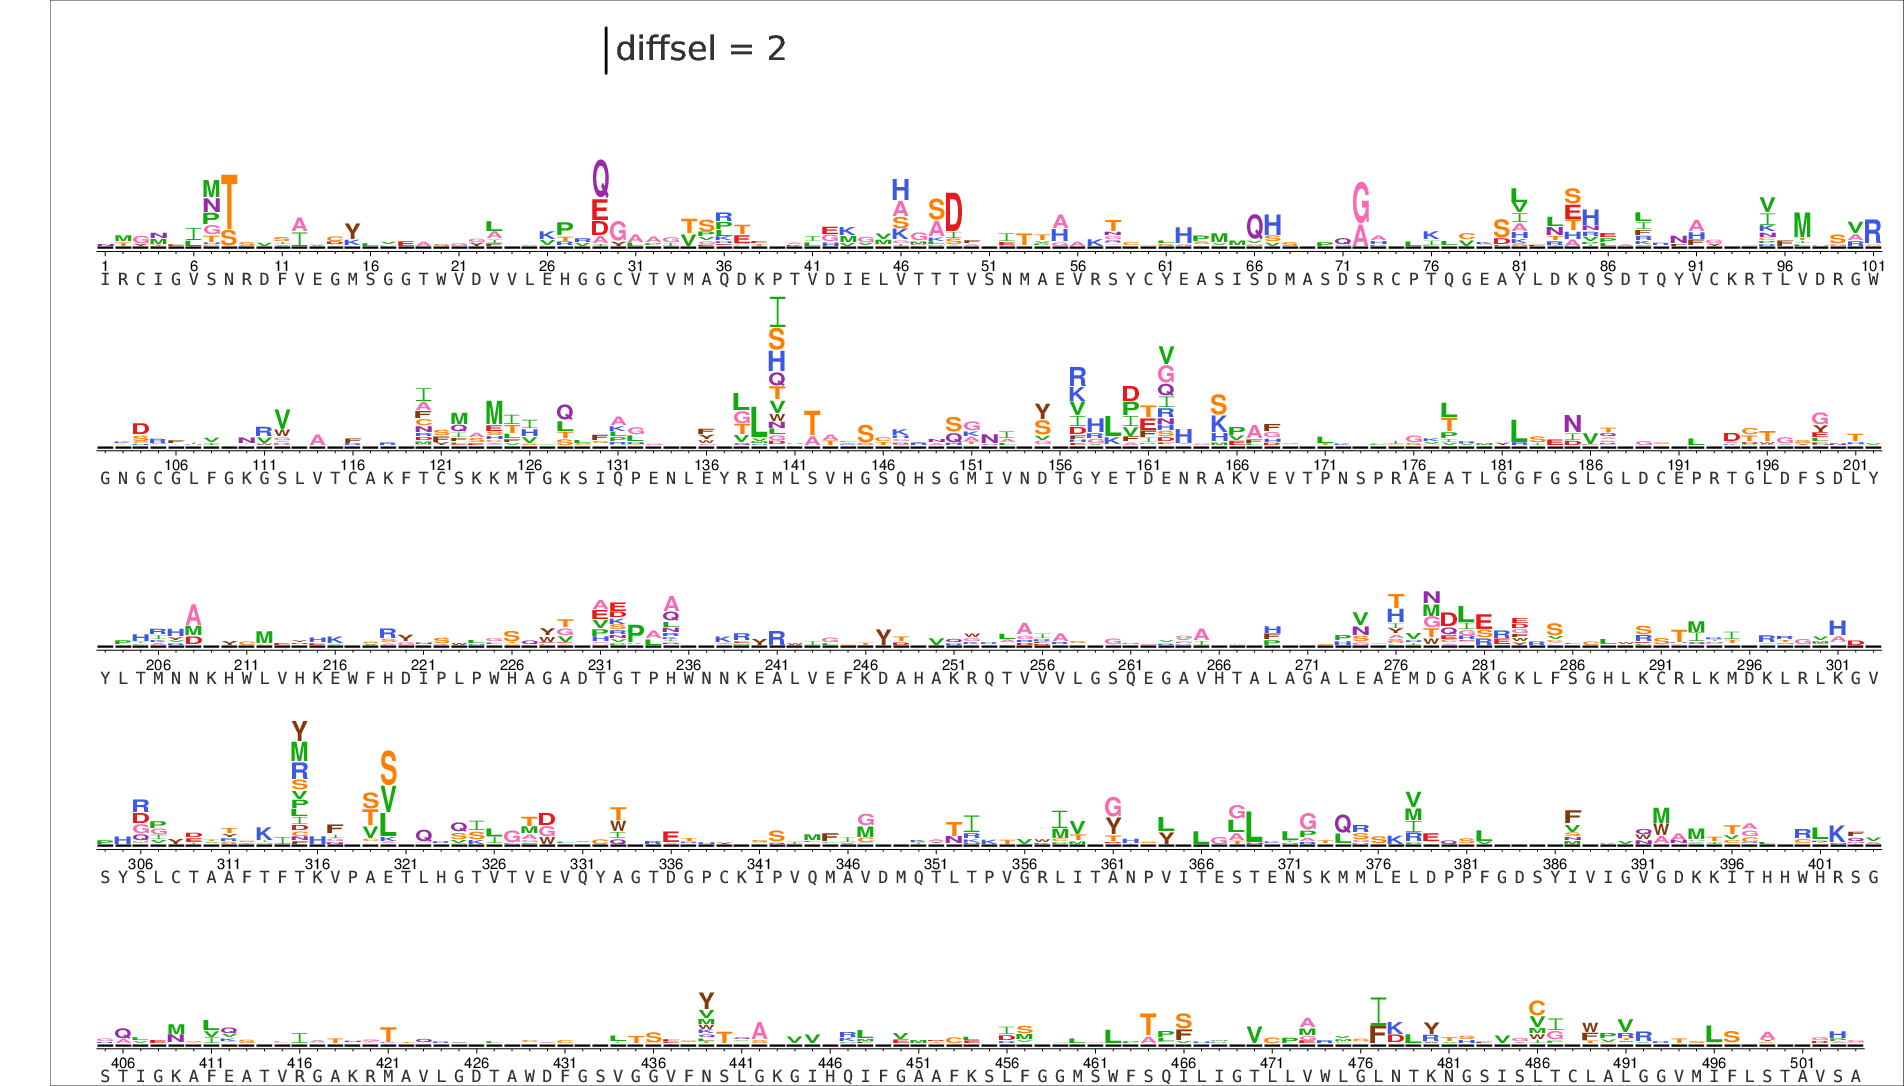

In [19]:
# Also show median across concentrations (mostly for SIgN-3C)
diffselprefix = diffseldir + '/summary_'

# Initialize empty lists
medianfiles = []
medavgsitefiles = []
logoplots = []

# Define dictionary of sites of interest for zooms
zoom_dictionary = {}

# Iteration through antibodies; generate protein-wide logoplots
for antibody in diffsel_batch['antibody'].unique():
    print('\nGetting and plotting overall across-concentration median for {0}'.format(antibody))
    
    # list of files
    mediandiffsel_files = glob.glob('{0}*{1}-*medianmutdiffsel.csv'
            .format(diffselprefix, antibody))
    
    # Average across mutation fraction surviving
    medianmutdf = dms_tools2.diffsel.avgMutDiffSel(
            mediandiffsel_files, 'median')
    print('Here are the top 5 mutation-level effects...')
    print(medianmutdf.head(5))
    

    # Convert median mutation to median avg site fract            ion surviving
    avgsitedf = dms_tools2.diffsel.mutToSiteDiffSel(
            medianmutdf)
    print('Here are the top 10 site-level effects...')
    print(avgsitedf
          [['site', 'positive_diffsel']]
          .sort_values(by=['positive_diffsel'], ascending=False)
          .reset_index(drop=True)
          .head(10))
    
    # Write median mutation fracsurvive dataframe to csv files
    medianfile = os.path.join(diffseldir, 
            'antibody_{0}_median.csv'.format(antibody))
    medianfiles.append(medianfile)
    print("Writing across-concentration medians to {0}".format(
            medianfile))
    medianmutdf.to_csv(medianfile, index=False)
    
    # Write median average site fracsurvive dataframe to csv files
    avgsitefile = os.path.join(diffseldir,
            'antibody_{0}_median_avgsite.csv'.format(antibody))
    medavgsitefiles.append(avgsitefile)
    print("Writing across-concentration site medians to {0}".format(
            avgsitefile))
    avgsitedf.to_csv(avgsitefile, index=False)
    
    # Define antibody sites of interest and save to zoom dictionary
    top_sites = (avgsitedf.sort_values(by=['positive_diffsel'], ascending=False)['site'].head(2).to_list())
    top_muts = (medianmutdf.sort_values(by=['mutdiffsel'], ascending=False)['site'].head(2).to_list())
    
    unique_sites = list(set(top_sites + top_muts))
        
    zoom_dictionary[antibody] = unique_sites
    
    print(zoom_dictionary)
    
    # now make logo plot
    # scale bar unit is maximum effect
    scaleunit = '{0:.1g}'.format(medianmutdf['mutdiffsel'].max())
    scalelabel = '"diffsel = {0}"'.format(scaleunit)
    logoplot = os.path.join(diffseldir,
            '{0}_diffsel.pdf'.format(antibody))
    logoplots.append(logoplot)
    print("Creating logo plot {0} for {1} from {2}".format(
            logoplot, antibody, medianfile))
    log = !dms2_logoplot \
            --diffsel {medianfile} \
            --name {antibody} \
            --outdir {diffseldir} \
            --restrictdiffsel positive \
            --numberevery 5 \
            --nperline 101 \
            --colormap colorwheel \
            --underlay yes \
            --overlay1 {medianfile} wildtype wildtype \
            --scalebar {scaleunit} {scalelabel} \
            --use_existing {use_existing}

    showPDF(logoplot)
    
zoom_dictionary['EDE1-C10'] = sorted(list(set(zoom_dictionary['EDE1-C10'] + zoom_dictionary['EDE1-C8'])))
zoom_dictionary['EDE1-C8'] = sorted(list(set(zoom_dictionary['EDE1-C10'] + zoom_dictionary['EDE1-C8'])))


# Figures for the paper
Next we will produce various plots for the paper. Namely: logoplots of functional epitopes; mutational tolerance analysis; tables of relevant data to include in the supplement. 

## Zoomed-in logoplots of regions of interest
These zoomed-in logoplots (composed of sites with largest site- and mutation-level effects) will be used to compare to structural epitopes. We will scale per-antibody.

In [20]:
# make directory for figures
figsdir = os.path.join(resultsdir, 'figures')
os.makedirs(figsdir, exist_ok = True)

In [21]:
zoom_dictionary

{'ZV-67': [333, 310],
 'MZ4': [368, 301, 479],
 'EDE1-C10': [7, 33, 49, 283, 315, 397, 439],
 'EDE1-C8': [7, 33, 49, 283, 315, 397, 439],
 'SIgN-3C': [8, 72, 315, 140]}

showing zoomed logoplot for ZV-67...


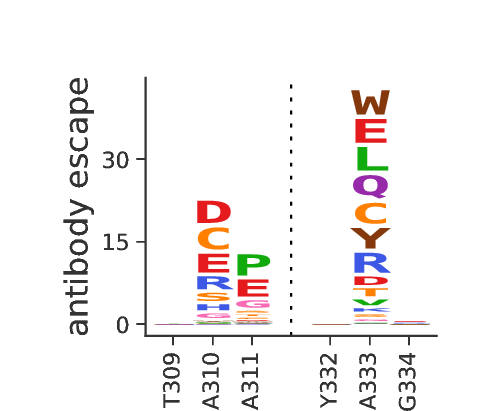

showing zoomed logoplot for MZ4...


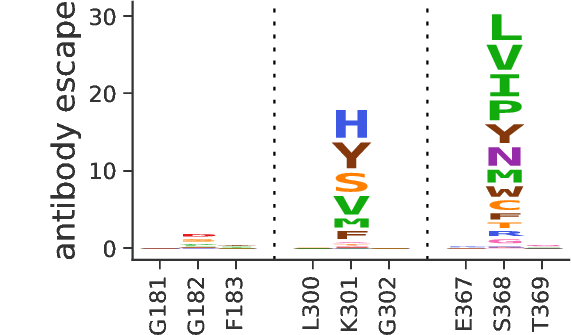

showing zoomed logoplot for EDE1-C10...


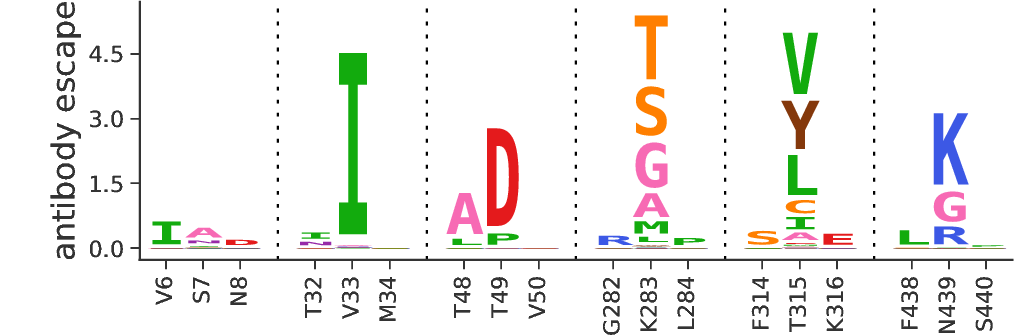

showing zoomed logoplot for EDE1-C8...


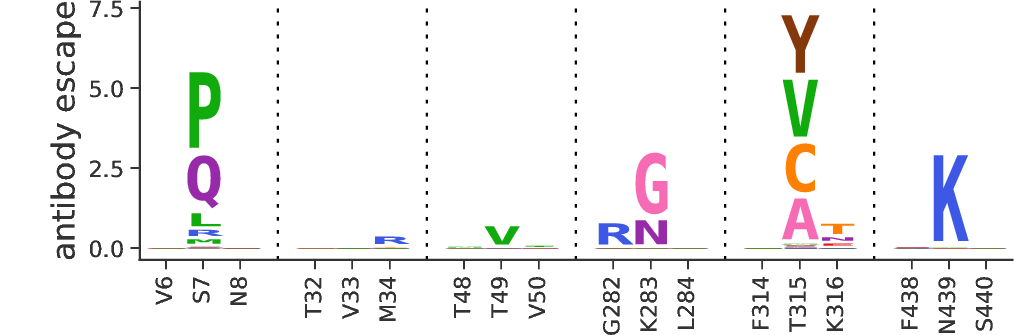

showing zoomed logoplot for SIgN-3C...


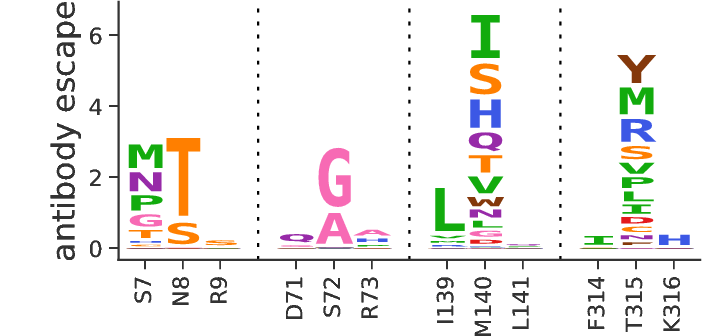

In [22]:
plt.clf()
# Set plot style
sns.set(style = 'white') 

# Make logoplots for each antibody
for ab in zoom_dictionary.keys():
    
    # Access sites from zoomsites dictionary
    sites = zoom_dictionary[ab]
    
    # Specific to MZ4 - rather than show one of the sites, show 182
    sites = [182 if x == 479 else x for x in sites]
    
    # Specific to EDE1 - skip 439 and 397 to save space
    # sites = [ele for ele in sites if ele != 439]
    sites = [ele for ele in sites if ele != 397]



    
    above_sites = [x + 1 for x in sites]
    below_sites = [x - 1 for x in sites]
    
    sites = sites + above_sites + below_sites

    # Get dataframe of antibody selections diffsel data
    df = pd.read_csv(diffseldir + f"/antibody_{ab}_median.csv")
    
    # Zoom in on sites identified in dictionary 
    zoomed_df = (df
                 .loc[df['site'].isin(sites)]
                )

    # Add a site label that includes the wildtype amino acid
    zoomed_df = zoomed_df.assign(site_label = lambda x: x['wildtype'] + x['site'].astype(str))
    
    # Floor selection at 0
    zoomed_df['mutdiffsel'] = zoomed_df['mutdiffsel'].mask(zoomed_df['mutdiffsel'].lt(0),0)
    
    # Draw and save the plots
    fig, axes = dmslogo.draw_logo(
        data=zoomed_df,
        x_col='site',
        letter_col='mutation',
        letter_height_col='mutdiffsel',
        addbreaks=True,
        xtick_col='site_label',
        ylabel = 'antibody escape',
        xlabel = '',
        # colorscheme = colorwheel
    )
    
    # Save to figures directory
    antibodyzoom = os.path.join(figsdir, f'{ab}_zoom.pdf')
    fig.savefig(antibodyzoom, bbox_inches='tight')
    
    print(f'showing zoomed logoplot for {ab}...')
    showPDF(antibodyzoom)

## Create polyclonal analysis input files 
To visualize results on 3D protein structures, we will use the b-factor reassignment function defined in polyclonal. We will use site-level summed differential selection (our metric for 'antibody escape') as b-factors. 

In [23]:
# make reassigned bfactor results subfolder
reassignedpdbdir = os.path.join(resultsdir, 'reassignedpdb/')
os.makedirs(reassignedpdbdir, exist_ok=True)

In [24]:
# Get dataframe of input files for b-factor assignment 
pointers = (diffsel_batch
                            .assign(sitediffsel = lambda x: (diffseldir + '/antibody_' + 
                                               x['antibody'] + '_median_avgsite.csv')
                                   )
                            [['antibody','sitediffsel']]
                            .drop_duplicates()
                            .reset_index(drop=True)
                           )
                
                        
pointers

,antibody,sitediffsel
0,ZV-67,./results/diffsel/antibody_ZV-67_median_avgsit...
1,MZ4,./results/diffsel/antibody_MZ4_median_avgsite.csv
2,EDE1-C10,./results/diffsel/antibody_EDE1-C10_median_avg...
3,EDE1-C8,./results/diffsel/antibody_EDE1-C8_median_avgs...
4,SIgN-3C,./results/diffsel/antibody_SIgN-3C_median_avgs...


In [25]:
# make base dataframe to add protein labels to
# these should contain sites, wt, mutation, condition 
# as well as the PDB file protein_chain and protein_site
# these will include mut_* values since we are interested in mapping escape mutants

# make dataframe for all conditions/concentrations with site, wt, mut and mutdiffsel values
pdbdf = pd.DataFrame()

for index, info in pointers.iterrows():
    ab = info.str.split('/t')[0][0]
    sitediffselcsv = info.str.split('/t')[1][0]
    
    pdbdf = (pdbdf.append(pd.read_csv(sitediffselcsv)
                          [['site','positive_diffsel']]
                          .sort_values(by = ['site'])
                          .reset_index(drop=True)
                          .assign(condition = ab,
                                 )
                         )
            )
          

print('Here is the diffsel dataframe we will add protein labels to...')
pdbdf

Here is the diffsel dataframe we will add protein labels to...


,site,positive_diffsel,condition
0,1,0.000000,ZV-67
1,2,1.518964,ZV-67
2,3,1.454714,ZV-67
3,4,1.067576,ZV-67
4,5,0.223613,ZV-67
...,...,...,...
499,500,0.000000,SIgN-3C
500,501,0.000000,SIgN-3C
501,502,0.299438,SIgN-3C
502,503,0.592304,SIgN-3C


In [26]:
# homodimer polyclonal analysis input file
homodimer_polyclonal_df = pd.DataFrame() 

# in 5ire protein structure, the three chains of E homodimer (+1 monomer) are labeled 'A', 'C', and 'E' 
# here, iteratively add the label 'A', 'C', or 'E' to each site
# the product dataframe will basically be three times the size
chainlist = ['A', 'C', 'E']
templist = []

ab_dict = {'EDE1-C10' : 'EDE1_C10',
           'EDE1-C8' : 'EDE1_C8',
           'ZKA-64' : 'ZKA_64',
           'ZV-67' : 'ZV_67',
           'SiGN-3C' : 'SiGN_3C'}
    
for chain in chainlist:
    templist.append(pdbdf
                    .assign(protein_chain = chain,
                            protein_site = lambda x: x['site'],
                            label_site = lambda x: x['site'])
                   )

homodimer_polyclonal_df = (homodimer_polyclonal_df
                           .append(templist)
                           .replace(ab_dict)
                          )
                           

# save these files and preview dataframe
medianfracsurvivecsv = os.path.join(reassignedpdbdir, 'alldiffsel.csv')
homodimer_polyclonal_df.to_csv(medianfracsurvivecsv, index=False, float_format='%.3g')

print(f"Writing CSV to {medianfracsurvivecsv}; here is a preview...")
homodimer_polyclonal_df

Writing CSV to ./results/reassignedpdb/alldiffsel.csv; here is a preview...


,site,positive_diffsel,condition,protein_chain,protein_site,label_site
0,1,0.000000,ZV_67,A,1,1
1,2,1.518964,ZV_67,A,2,2
2,3,1.454714,ZV_67,A,3,3
3,4,1.067576,ZV_67,A,4,4
4,5,0.223613,ZV_67,A,5,5
...,...,...,...,...,...,...
499,500,0.000000,SIgN-3C,E,500,500
500,501,0.000000,SIgN-3C,E,501,501
501,502,0.299438,SIgN-3C,E,502,502
502,503,0.592304,SIgN-3C,E,503,503


In [27]:
ablist = ['EDE1_C10',
          'EDE1_C8',
          'MZ4',
          'ZV_67', 
          'SiGN_3C']

for ab in ablist:
    df = homodimer_polyclonal_df.query('condition == "' + str(ab) + '"')
    csv = os.path.join(reassignedpdbdir, ab + '_diffsel.csv')
    df.to_csv(csv, index = False)
    print(f'Writing CSV for {ab} to {csv}...')

Writing CSV for EDE1_C10 to ./results/reassignedpdb/EDE1_C10_diffsel.csv...
Writing CSV for EDE1_C8 to ./results/reassignedpdb/EDE1_C8_diffsel.csv...
Writing CSV for MZ4 to ./results/reassignedpdb/MZ4_diffsel.csv...
Writing CSV for ZV_67 to ./results/reassignedpdb/ZV_67_diffsel.csv...
Writing CSV for SiGN_3C to ./results/reassignedpdb/SiGN_3C_diffsel.csv...


# Functional analysis
To ask and answer questions about how different mutational tolerance across E protein (at both the individual amino acid mutation-level and at the site-level) might affect antibody escape, we will generate per-antibody scatter plots comparing different mutational tolerance/flexibility metrics to antibody escape. 

## Site-level flexibility versus site-level antibody escape
Here, we can use functional score estimates from the work performed in Sourisseau et al to compute site-level flexibility. We can compare these metrics to site-level antibody escape to see whether narrow antibodies target more flexible sites (relative to broad antibodies)

In [28]:
# Define colors
colors = {'teal': '#3bceac',
          'red': '#DA2C38',
          'blue': '#446df6',
          'yellow': '#F6AE2D',
          'green': '#00635D',
         }

In [29]:
# ID functional data directory
functionaldatadir = os.path.join(datadir, 'functional_data')

# Read in mutation-level preferences data
unscaledprefsfile = os.path.join(functionaldatadir, 'unscaled_prefs.csv')
unscaledprefs = pd.read_csv(unscaledprefsfile)
unscaledprefs.head()

,site,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
0,1,0.005438,0.009065,0.012163,0.009180,0.008687,0.004282,0.003339,0.179643,0.003888,...,0.279248,0.008542,0.001240,0.011589,0.001585,0.003096,0.316543,0.112591,0.016822,0.008731
1,2,0.007809,0.018669,0.021458,0.018187,0.018150,0.062636,0.026099,0.015878,0.026583,...,0.021237,0.022353,0.006953,0.019685,0.579880,0.023507,0.012992,0.012776,0.052111,0.024828
2,3,0.006306,0.715622,0.031189,0.018934,0.019171,0.010131,0.011007,0.010956,0.012948,...,0.019899,0.012324,0.004083,0.013883,0.010874,0.016100,0.007397,0.006839,0.015366,0.052559
3,4,0.012582,0.021175,0.026134,0.025855,0.021090,0.014896,0.013630,0.436679,0.013627,...,0.074051,0.043320,0.006742,0.020199,0.005229,0.014981,0.027572,0.153553,0.033425,0.018557
4,5,0.009296,0.011905,0.017206,0.036911,0.012321,0.766760,0.009187,0.006683,0.010623,...,0.026395,0.010510,0.004116,0.012365,0.012495,0.006081,0.004521,0.013316,0.014955,0.011066


In [30]:
# Make logoplots for same zoomsites as above

# Make base dataframe
tidy_unscaledprefs = (unscaledprefs
                        .melt(id_vars=['site'],
                              var_name='aa',
                              value_name='unscaledpref'
                             )        
                )

# Iterate through zoomsites and make plots

for ab in zoom_dictionary.keys():
    # Access sites from zoomsites dictionary
    sites = zoom_dictionary[ab]

    # Zoom in on sites identified in dictionary 
    zoomed_unscaledprefs = (tidy_unscaledprefs
                 .loc[tidy_unscaledprefs['site'].isin(sites)]
                )

    # Draw and save the plots
    fig, axes = dmslogo.draw_logo(
        data=zoomed_unscaledprefs,
        x_col='site',
        ylabel = 'mut tolerance',
        letter_col='aa',
        letter_height_col='unscaledpref',
        # colorscheme = colorwheel
    )
    
    # Save to figures directory
    prefsantibodyzoom = os.path.join(figsdir, f'prefs_{ab}_zoom.pdf')
    fig.savefig(prefsantibodyzoom, bbox_inches='tight', dpi = 'figure')
    print(f'saving zoomed preferences for {ab} at selected zoomsites...')
    # showPDF(prefsantibodyzoom)

saving zoomed preferences for ZV-67 at selected zoomsites...
saving zoomed preferences for MZ4 at selected zoomsites...
saving zoomed preferences for EDE1-C10 at selected zoomsites...
saving zoomed preferences for EDE1-C8 at selected zoomsites...
saving zoomed preferences for SIgN-3C at selected zoomsites...


In [31]:
# We can also look at the site-level
# For this, the 2019 Sourisseau paper has 2 metrics, neffective and site entropy
muteffectsfile = os.path.join(functionaldatadir, 'struct_props_mut_tol.csv')
muteffects = pd.read_csv(muteffectsfile)[['site','mutational_tolerance_measure','mutational_tolerance']].drop_duplicates()
muteffects.query('site == 1')

,site,mutational_tolerance_measure,mutational_tolerance
0,1,entropy,1.809948
2004,1,neffective,6.110127


In [32]:
# Separate mutational tolerance methods
muteffects_reform = (muteffects
                      .query('mutational_tolerance_measure == "entropy"')
                      .rename(columns = {'mutational_tolerance': 'entropy'})
                      .merge(muteffects.query('mutational_tolerance_measure == "neffective"')
                            .rename(columns = {'mutational_tolerance': 'neffective'}), 
                            on = ['site'])
                     [['site','entropy','neffective']]
                     )
muteffects_reform.head()

,site,entropy,neffective
0,1,1.809948,6.110127
1,2,1.851241,6.367718
2,3,1.375274,3.956159
3,4,2.123703,8.362047
4,5,1.190491,3.288694


In [33]:
# Reformat dataframe
diffseldir = os.path.join(resultsdir, 'diffsel')

ab_list = diffsel_batch['antibody'].unique()


# Initialize empty dataframe for differential selection data of interest
diffsel_df = pd.DataFrame()

for ab in ab_list:
    file = glob.glob(os.path.join(diffseldir, 'antibody_' + str(ab) + "_median_avgsite.csv"))[0]
    print(f'For antibody {ab}, found median site diffsel at... {file}')
    
    # Get scratch dataframe from each antibody
    scratch_df = (pd.read_csv(file)
                  .assign(antibody = ab)
                 )  

    # Concatenate scratch and existing dataframe
    diffsel_df = pd.concat([diffsel_df, scratch_df])
    
# Rename IC50 dataframe to match variables in diffsel dataframe
df = (muteffects_reform
           .merge(diffsel_df, how = 'left', on = ['site']) # Then merge with diffsel data
          )
df.head()

For antibody ZV-67, found median site diffsel at... ./results/diffsel/antibody_ZV-67_median_avgsite.csv
For antibody MZ4, found median site diffsel at... ./results/diffsel/antibody_MZ4_median_avgsite.csv
For antibody EDE1-C10, found median site diffsel at... ./results/diffsel/antibody_EDE1-C10_median_avgsite.csv
For antibody EDE1-C8, found median site diffsel at... ./results/diffsel/antibody_EDE1-C8_median_avgsite.csv
For antibody SIgN-3C, found median site diffsel at... ./results/diffsel/antibody_SIgN-3C_median_avgsite.csv


,site,entropy,neffective,abs_diffsel,positive_diffsel,negative_diffsel,max_diffsel,min_diffsel,antibody
0,1,1.809948,6.110127,7.581099,0.000000,-7.581099,0.000000,-2.621183,ZV-67
1,1,1.809948,6.110127,7.239773,0.000000,-7.239773,0.000000,-2.508192,MZ4
2,1,1.809948,6.110127,6.473181,0.000000,-6.473181,0.000000,-2.140399,EDE1-C10
3,1,1.809948,6.110127,5.938759,0.001424,-5.937335,0.001424,-2.731474,EDE1-C8
4,1,1.809948,6.110127,2.841469,0.131642,-2.709827,0.131573,-0.978957,SIgN-3C


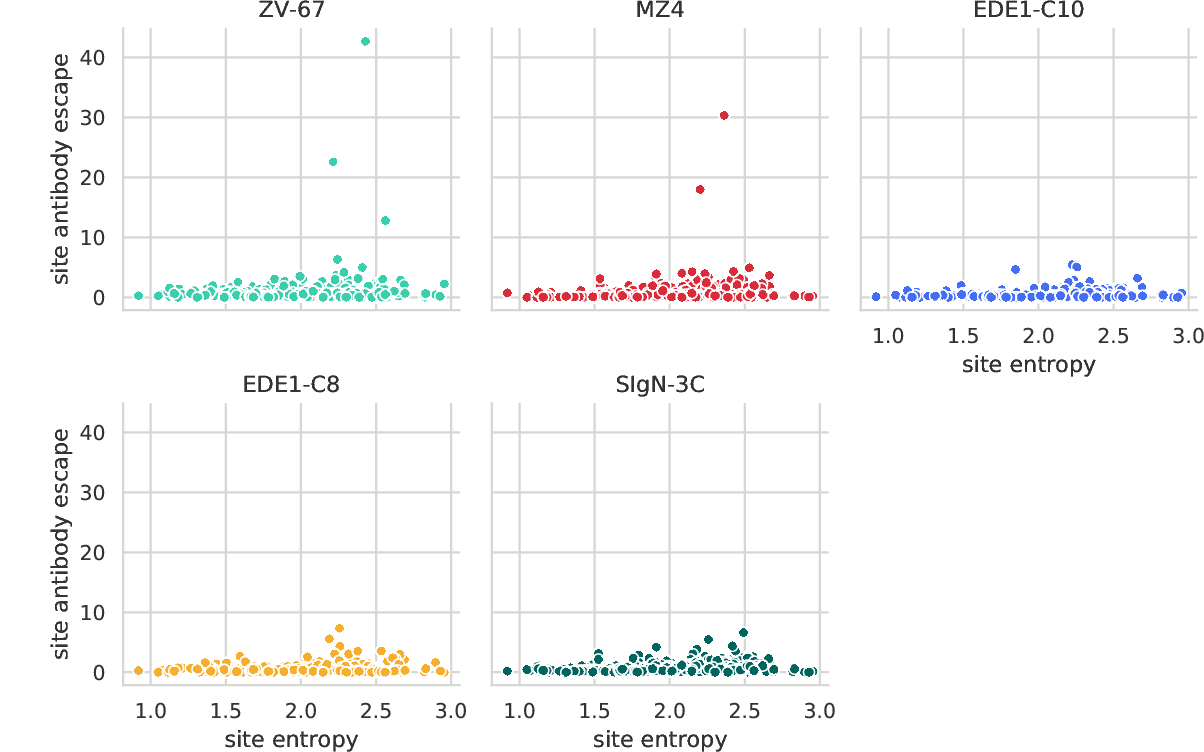

In [34]:
# Using entropy, facet by antibody so we can see individal plots more easily
plt.clf()
# Set plot style
sns.set(style = 'white') 
# Set plot size
plt.figure(figsize=(6,6)) #width=8, height=4
# Set plot style
sns.set_style('whitegrid')

# Make dataframe
abdata = df.loc[df['antibody'].isin(['EDE1-C10', 'EDE1-C8', 'SIgN-3C', 'MZ4', 'ZV-67'])]

g = sns.FacetGrid(data = abdata, col = 'antibody', hue = 'antibody', palette = list(colors.values()),
                 col_wrap = 3, margin_titles=True)


g.map(sns.scatterplot, 
      'entropy', 
      'positive_diffsel',
     )

# Change titles and axes
g.set_ylabels('site antibody escape')
g.set_xlabels('site entropy')
g.set_titles(col_template="{col_name}")


# Save to figures directory
fig = os.path.join(figsdir,'site_entropy_vs_selection_faceted.pdf')
g.savefig(fig, dpi = 'figure')
showPDF(fig)

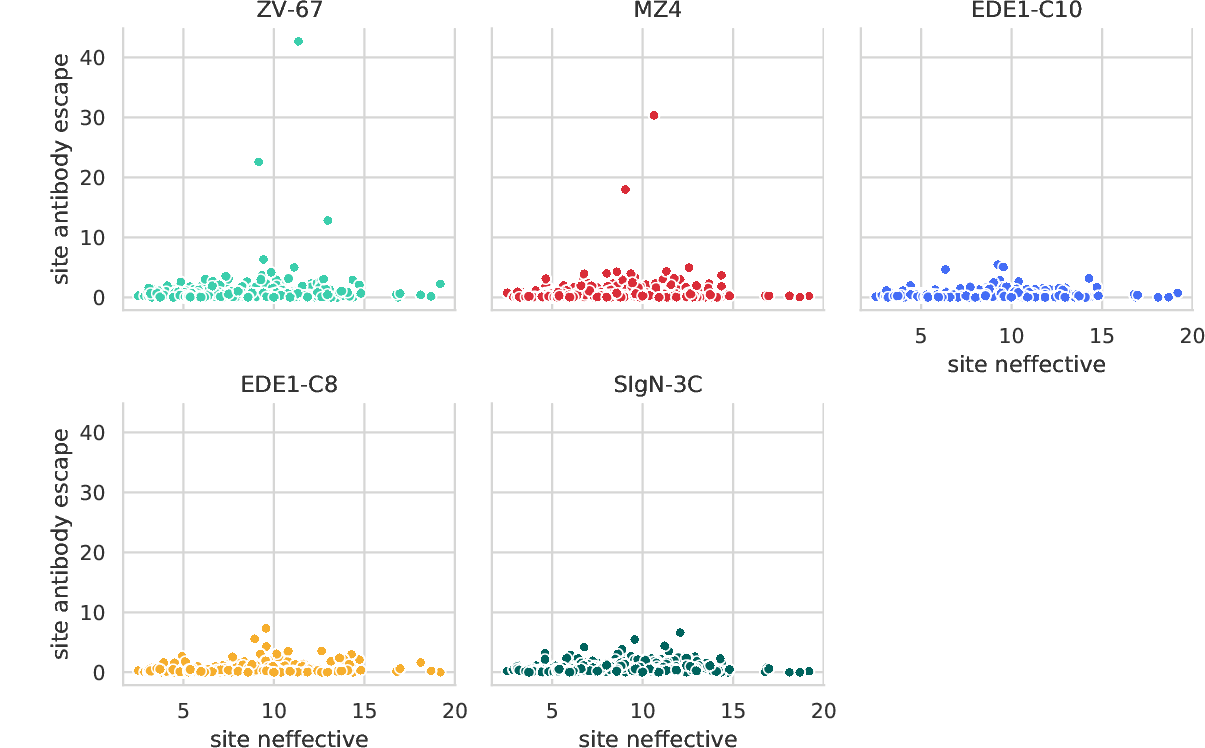

In [35]:
# Repeat using neffective, facet by antibody so we can see individal plots more easily

plt.clf()
# Set plot style
sns.set(style = 'white') 
# Set plot size
plt.figure(figsize=(6,6)) #width=8, height=4
# Set plot style
sns.set_style('whitegrid')

g = sns.FacetGrid(data = abdata, col = 'antibody', hue = 'antibody', palette = list(colors.values()),
                 col_wrap = 3, margin_titles=True)
g.map(sns.scatterplot, 
      'neffective', 
      'positive_diffsel',
     )

# Change titles and axes
g.set_titles(col_template="{col_name}")
g.set_ylabels('site antibody escape')
g.set_xlabels('site neffective')


# Save to figures directory
fig = os.path.join(figsdir,'site_neffective_vs_selection_faceted.pdf')
g.savefig(fig, dpi = 'figure')
showPDF(fig)

## Mutation-level amino acid tolerance compared to mutation-level antibody escape 
Similar to the above analysis, we can see whether particular antibody escape mutations targeted by narrow antibodies are more preferred relative to those targeted by broad antibodies. 

In [36]:
# First retrieve amino acid level diffsel
# Initialize empty dataframe for differential selection data of interest

mutdiffsel_df = pd.DataFrame()

for ab in ab_list:
    file = glob.glob(os.path.join(diffseldir, 'antibody_' + str(ab) + "_median.csv"))[0]
    print(f'For antibody {ab}, found median mutational diffsel at... {file}')
    
    # Get scratch dataframe from each antibody
    scratch_df = (pd.read_csv(file)
                  .assign(antibody = ab)
                 )  

    # Concatenate scratch and existing dataframe
    mutdiffsel_df = pd.concat([mutdiffsel_df, scratch_df])
    
mutdiffsel_df = mutdiffsel_df.assign(isite = lambda x: x.site.astype(str) + x.mutation)

For antibody ZV-67, found median mutational diffsel at... ./results/diffsel/antibody_ZV-67_median.csv
For antibody MZ4, found median mutational diffsel at... ./results/diffsel/antibody_MZ4_median.csv
For antibody EDE1-C10, found median mutational diffsel at... ./results/diffsel/antibody_EDE1-C10_median.csv
For antibody EDE1-C8, found median mutational diffsel at... ./results/diffsel/antibody_EDE1-C8_median.csv
For antibody SIgN-3C, found median mutational diffsel at... ./results/diffsel/antibody_SIgN-3C_median.csv


In [37]:
# We already have a dataframe of unmerged prefs
tidy_unscaledprefs = tidy_unscaledprefs.assign(isite = lambda x: x.site.astype(str) + x.aa)

# Rename IC50 dataframe to match variables in diffsel dataframe and merge
tidy_mutdiffsel_df = (tidy_unscaledprefs
                      .merge(mutdiffsel_df, how = 'left', on = ['isite', 'site']) # Then merge with diffsel data
                     )

tidy_mutdiffsel_df = (tidy_mutdiffsel_df
                      .assign(mutant = lambda x: x.wildtype + x.isite)
                      [['site', 'wildtype', 'mutation', 'mutant', 'unscaledpref', 'mutdiffsel', 'antibody']]
                     )

# We should also scale prefs by the WT preference
wtprefs_df = (tidy_mutdiffsel_df
              .query('wildtype == mutation')
              .sort_values(by = ['site', 'wildtype', 'mutation'])
              [['site', 'unscaledpref']]
              .drop_duplicates()
              .rename(columns = {'unscaledpref': 'wtpref'})
             )

prefs_vs_mutdiffsel_df = (wtprefs_df
           .merge(tidy_mutdiffsel_df)
          )

prefs_vs_mutdiffsel_df = prefs_vs_mutdiffsel_df.assign(scaledpref = lambda x: x.unscaledpref / x.wtpref)

# Drop WT sites
prefs_vs_mutdiffsel_df = prefs_vs_mutdiffsel_df.dropna()

# Add log-transformed scaled preferences
prefs_vs_mutdiffsel_df['logscaledpref'] = np.log2(prefs_vs_mutdiffsel_df['scaledpref'])
prefs_vs_mutdiffsel_df.head()

,site,wtpref,wildtype,mutation,mutant,unscaledpref,mutdiffsel,antibody,scaledpref,logscaledpref
0,1,0.179643,I,A,I1A,0.005438,-0.000814,ZV-67,0.030269,-5.04603
1,1,0.179643,I,A,I1A,0.005438,-0.000861,MZ4,0.030269,-5.04603
2,1,0.179643,I,A,I1A,0.005438,-0.000740,EDE1-C10,0.030269,-5.04603
3,1,0.179643,I,A,I1A,0.005438,-0.000542,EDE1-C8,0.030269,-5.04603
4,1,0.179643,I,A,I1A,0.005438,-0.000001,SIgN-3C,0.030269,-5.04603


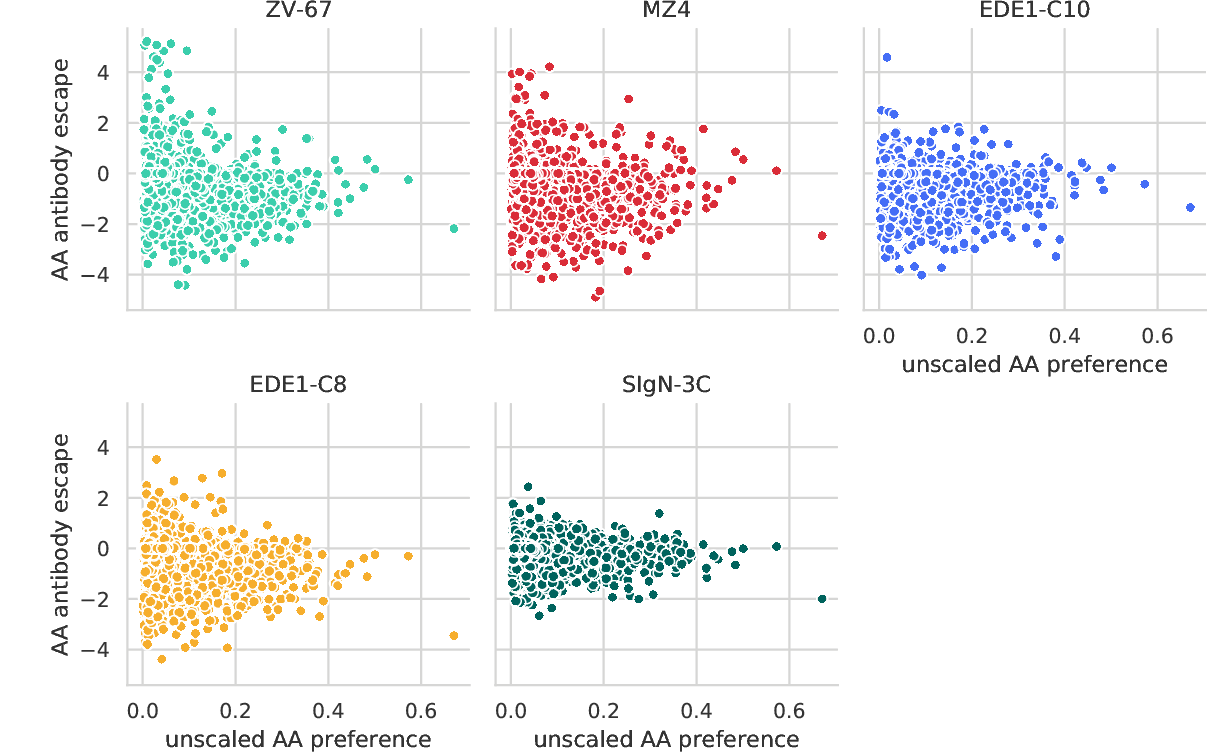

In [38]:
# Plot scatters faceted by antibody

plt.clf()
# Set plot style
sns.set(style = 'white') 
# Set plot size
plt.figure(figsize=(6,6)) #width=8, height=4
# Set plot style
sns.set_style('whitegrid')

# Make dataframe
# abdata = df.loc[df['antibody'].isin(['EDE1-C10', 'EDE1-C8', 'SIgN-3C', 'MZ4', 'ZV-67'])]

g = sns.FacetGrid(data = prefs_vs_mutdiffsel_df, col = 'antibody', hue = 'antibody', palette = list(colors.values()),
                 col_wrap = 3)
g.map(sns.scatterplot, 
      'unscaledpref', 
      'mutdiffsel',
     )

# Change titles and axes
g.set_titles(col_template="{col_name}")
g.set_ylabels('AA antibody escape')
g.set_xlabels('unscaled AA preference')


# Save to figures directory
fig = os.path.join(figsdir,'mutationlevel_pref_vs_diffsel.pdf')
g.savefig(fig, dpi = 'figure')
showPDF(fig)

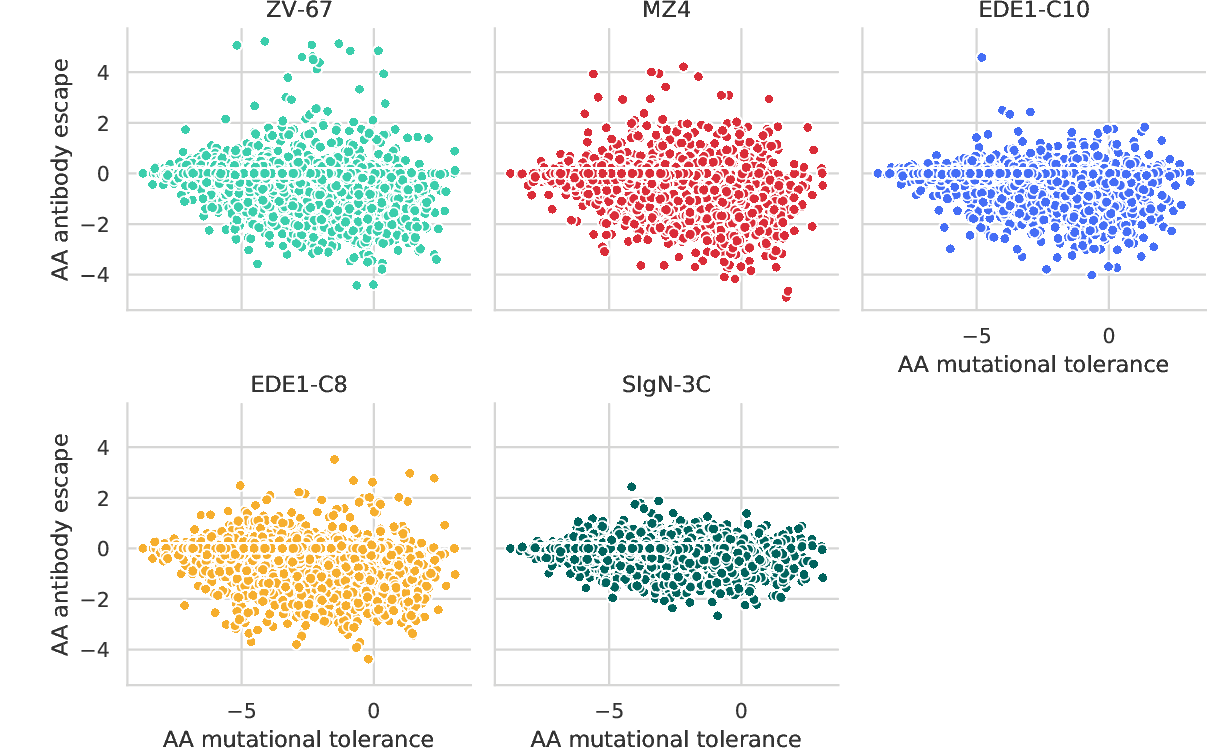

In [39]:
# We should also scale prefs by the WT preference
# Plot scatters faceted by antibody
plt.clf()
# Set plot style
sns.set(style = 'white') 
# Set plot size
plt.figure(figsize=(6,6)) #width=8, height=4
# Set plot style
sns.set_style('whitegrid') 

# Make dataframe
# abdata = df.loc[df['antibody'].isin(['EDE1-C10', 'EDE1-C8', 'SIgN-3C', 'MZ4', 'ZV-67'])]

g = sns.FacetGrid(data = prefs_vs_mutdiffsel_df, col = 'antibody', hue = 'antibody', palette = list(colors.values()),
                 col_wrap = 3)
g.map(sns.scatterplot, 
      'logscaledpref', 
      'mutdiffsel',
     )

# Change titles and axes
g.set_titles(col_template="{col_name}")
g.set_ylabels('AA antibody escape')
g.set_xlabels('AA mutational tolerance')

# Save to figures directory
fig = os.path.join(figsdir,'mutationlevel_SCALEDpref_vs_diffsel.pdf')
g.savefig(fig, dpi = 'figure')
showPDF(fig)

# Table figures for the paper
For the supplement, it will be nice to have a table of percent infectivity and antibody concentration used for each replicate. I will generate a PDF of a subset of 'diffsel_batch', defined above. 

In [40]:
percentinfect_table = (diffsel_batch
                       .assign(conc = lambda x: x['grouplabel'].str.split('(').str[1].str.split(')').str[0],
                               temp = lambda x: x['name'],
                               index = lambda x: x['name'].str.strip('lib')
                              )
                      [['antibody', 'conc', 'temp', 'percent_infectivity']]
                       .reset_index(drop=True)
                       
                      )

percentinfect_table['concentration'] = (percentinfect_table['conc']
                                        .str.split(' ').str[0] + ' ng/$\mu$L')

percentinfect_table['temp'] = (percentinfect_table['temp']
                                        .str.replace('-v2', 'v2')
                                             )

percentinfect_table = (percentinfect_table
                       .assign(dmslibrary = lambda x: x['temp'].str.split('-').str[0])
                       .rename(columns = {'percent_infectivity': 'percent infectivity',
                                          'dmslibrary': 'DMS library'})
                       [['antibody', 'concentration', 'DMS library', 'percent infectivity']]
                      )

percentinfect_table

,antibody,concentration,DMS library,percent infectivity
0,ZV-67,40000 ng/$\mu$L,replicate1,0.84%
1,ZV-67,40000 ng/$\mu$L,replicate2,0.89%
2,ZV-67,40000 ng/$\mu$L,replicate3,0.01%
3,MZ4,4800 ng/$\mu$L,replicate1,0.46%
4,MZ4,4800 ng/$\mu$L,replicate2,0.02%
5,MZ4,4800 ng/$\mu$L,replicate3,0.05%
6,EDE1-C10,300 ng/$\mu$L,replicate1,0.11%
7,EDE1-C10,300 ng/$\mu$L,replicate2,0.23%
8,EDE1-C10,300 ng/$\mu$L,replicate3,0.39%
9,EDE1-C8,1800 ng/$\mu$L,replicate1,0.01%


In [41]:
# We will render figures in other notebooks
outdir = './paper_figures/neutralizations_escape_mutants/data/'
os.makedirs(outdir, exist_ok=True)

outfile = os.path.join(outdir, 'percent_infectivity_table.csv')
percentinfect_table.to_csv(outfile,
                             index=False,) 